# 1. EDA


## 1.1   Data Preprocessing, EDA & Model Building Liberaries

In [ ]:
import pandas as pd # Data manipulation
import numpy as np # Numerical operations
import math # Mathematical functions
import seaborn as sns  # Data visualization
import scipy.stats as stats # Statistical functions
import matplotlib.pylab as plt  # Plotting
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


* Imported core libraries for data manipulation and numerical computation (pandas, numpy).

* Used Seaborn and Matplotlib for exploratory data visualization.

* Included SciPy for statistical analysis during EDA.

* Loaded scikit-learn utilities for data preprocessing, model building, and evaluation.

* Set a fixed random seed (RANDOM_STATE = 42) to ensure reproducibility of results across runs.


## 1.2   Loading the Dataset¶

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/Group Project/telecom_customer_churn.csv')


# Load dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/ML/Group Project/telecom_customer_churn.csv'

Mounted at /content/drive


## 1.3 Data Preparation and Extensions Importing

In [ ]:
# Use encoding='latin1' to avoid UnicodeDecodeError
df = pd.read_csv(file_path, encoding='latin1')

# Clean column names
df.columns = df.columns.str.lower().str.strip()


* The dataset was loaded using latin1 encoding to handle non-UTF characters and avoid decoding errors.

* Column names were standardized by converting them to lowercase and removing leading/trailing whitespace.

* This normalization ensures consistent column referencing and reduces the risk of errors during analysis and modeling.

In [ ]:
# Drop irrelevant / redundant variables
to_drop = [
    "customer id",   # unique identifier
    "zip code",      # proxy identifier
    "latitude",      # implicit identifier
    "longitude",     # implicit identifier

]

df = df.drop(columns=to_drop, errors="ignore")

* `customer id`: A unique identifier with no analytical or predictive value; including it would add noise without contributing meaningful information.

* `zip code`: Acts as a proxy identifier and may introduce spurious geographic correlations without providing direct behavioral insight.

* `latitude`: Encodes location information implicitly and can function as a quasi-identifier, increasing the risk of overfitting without clear causal relevance.

* `longitude`: Similar to latitude, this variable indirectly identifies location and may bias the model toward geographic patterns rather than customer behavior.

In [ ]:
# Creating a new column for the Churned clients based on Customer Status
df["churned"] = df["customer status"].apply(lambda x: "Yes" if x == "Churned" else "No")

* Created a new binary target variable `churned` derived from the existing `customer status` field.

* Customers labeled as `churned` were mapped to "Yes", while all other statuses were mapped to "No".

In [ ]:
summary = pd.DataFrame({
    "Column": df.columns,
    "Missing": df.isna().sum().values,
    "Missing %": df.isna().mean().values,
    "Dtype": df.dtypes.astype(str).values
})

numeric_stats = (
    df.select_dtypes(include=["number"])
      .agg(["mean", "std", "min", "max"])
      .T
)

summary = summary.merge(
    numeric_stats,
    left_on="Column",
    right_index=True,
    how="left"
)

styled = (
    summary
    .style
    .format({
        "Missing": "{:,}",
        "Missing %": "{:.2%}",
        "mean": "{:.2f}",
        "std": "{:.2f}",
        "min": "{:,.0f}",
        "max": "{:,.0f}",
    }, na_rep="—")
    .background_gradient(subset=["Missing %"], cmap="Reds")
    .background_gradient(subset=["mean", "std"], cmap="Blues")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("font-weight", "bold")]},
        {"selector": "td", "props": [("padding", "6px")]},
    ])
)

styled

,Column,Missing,Missing %,Dtype,mean,std,min,max
0,gender,0,0.00%,object,—,—,—,—
1,age,0,0.00%,int64,46.51,16.75,19,80
2,married,0,0.00%,object,—,—,—,—
3,number of dependents,0,0.00%,int64,0.47,0.96,0,9
4,city,0,0.00%,object,—,—,—,—
5,number of referrals,0,0.00%,int64,1.95,3.00,0,11
6,tenure in months,0,0.00%,int64,32.39,24.54,1,72
7,offer,"3,877",55.05%,object,—,—,—,—
8,phone service,0,0.00%,object,—,—,—,—
9,avg monthly long distance charges,682,9.68%,float64,25.42,14.20,1,50


* Generated a consolidated summary table covering all features, including data type, missing values, and numeric distribution statistics.

* Calculated both absolute and percentage missing values to quickly identify incomplete features.

* Computed mean, standard deviation, minimum, and maximum for numerical variables only.

* Applied visual formatting to highlight:

  * Columns with higher missingness

  * Variability in numeric features

* Used consistent formatting to improve readability and support rapid exploratory assessment.

### Missing Values & Data Completeness
* Most demographic and billing-related variables (e.g., `age`, `tenure in months`, `contract`, `payment method`, `monthly charge`) have no missing values, indicating strong overall data quality.

* Several service-related features show systematic missingness, rather than random gaps.

* The variable `offer` has a high missing rate (55.05%), suggesting it applies only to a subset of customers.

* Phone-related features (`avg monthly long distance charges`, `multiple lines`) consistently show 9.68% missing values, corresponding to customers without phone service.

* Internet-related features (`internet type`, `avg monthly gb download`, `online security`, `online backup`, `device protection plan`, `premium tech support`, `streaming tv`, `streaming movies`, `streaming music`, `unlimited data`) consistently show 21.67% missing values, corresponding to customers without internet service.

* The variables `churn` category and `churn reason` have the highest missingness (73.46%), indicating these fields are only populated for churned customers.

### Numerical Feature Distributions
* `customer age` ranges from 19 to 80, with a mean of approximately 46.5, indicating a broadly distributed customer base.

* `tenure in months` spans from 1 to 72 months, showing a mix of new and long-term customers. The average `tenure in months` is about 32 months, with a wide spread, indicating a mix of short-term and long-term customers.

* Most customers have few or no dependents, as reflected by the low mean in `number of dependents`.

* Financial variables such as `monthly charge`, `total charges`, and `total revenue` exhibit high variance, suggesting heterogeneous customer value.

* The variables `total revenue` and `total charges` show particularly large standard deviations, highlighting the presence of high-value customers.

* A negative minimum value for `monthly charge` suggests discounts, adjustments, or refunds that may require validation.

* The churn rate (`churned`) is approximately 27%, indicating moderate class imbalance.


Phone Service and dependent columns


In [ ]:
# Count the number of "No" entries in the "phone service" column
count_no_phone_service = (df["phone service"] == "No").sum()
print("Count of 'No' in Phone Service:", count_no_phone_service)

# Columns to process
cols_ph = [
    "avg monthly long distance charges",
    "multiple lines"
]

# Count missing values in the specified columns
missing_counts = df[cols_ph].isna().sum()
print("\nMissing Values Count:")
print(missing_counts)

# Fill missing values based on column dtype
for col in cols_ph:
    if df[col].dtype == "object" or str(df[col].dtype) == "category":
        df[col] = df[col].fillna("No")
    else:
        df[col] = df[col].fillna(0)

# Optional: Verify that the missing values are filled
missing_counts_after_fill = df[cols_ph].isna().sum()
print("\nMissing Values Count After Filling:")
print(missing_counts_after_fill)

Count of 'No' in Phone Service: 682

Missing Values Count:
avg monthly long distance charges    682
multiple lines                       682
dtype: int64

Missing Values Count After Filling:
avg monthly long distance charges    0
multiple lines                       0
dtype: int64


An exploratory check confirmed that missing values in `avg monthly long distance charges` and `multiple lines` correspond to customers without phone service. This indicates structural missingness rather than data errors. To preserve semantic meaning, missing values were filled using domain-driven logic: "No" for `multiple lines` and 0 for `avg monthly long distance charges`. A post-imputation check verified that all missing values were successfully addressed.

Internet Service and dependent columns

In [ ]:
# Count the number of "No" entries in the "internet service" column
count_no_internet_service = (df["internet service"] == "No").sum()
print("Count of 'No' in Internet Service:", count_no_internet_service)

# Columns to process
cols_in = [
    "internet type", "avg monthly gb download", "online security",
    "online backup", "device protection plan", "premium tech support",
    "streaming tv", "streaming movies", "streaming music", "unlimited data"
]

# Count missing values in the specified columns
missing_counts = df[cols_in].isna().sum()
print("\nMissing Values Count:")
print(missing_counts)

# Fill missing values based on column dtype
for col in cols_in:
    if df[col].dtype == "object" or str(df[col].dtype) == "category":
        df[col] = df[col].fillna("No")
    else:
        df[col] = df[col].fillna(0)

# Optional: Verify that the missing values are filled
missing_counts_after_fill = df[cols_in].isna().sum()
print("\nMissing Values Count After Filling:")
print(missing_counts_after_fill)

Count of 'No' in Internet Service: 1526

Missing Values Count:
internet type              1526
avg monthly gb download    1526
online security            1526
online backup              1526
device protection plan     1526
premium tech support       1526
streaming tv               1526
streaming movies           1526
streaming music            1526
unlimited data             1526
dtype: int64

Missing Values Count After Filling:
internet type              0
avg monthly gb download    0
online security            0
online backup              0
device protection plan     0
premium tech support       0
streaming tv               0
streaming movies           0
streaming music            0
unlimited data             0
dtype: int64


Exploratory checks showed that missing values across internet-related features correspond to customers without internet service. This pattern indicates structural missingness driven by service eligibility. To preserve semantic meaning, missing categorical indicators were filled with "No", while `avg monthly gb download` was set to 0 to reflect no usage. A validation step confirmed that all missing values were successfully resolved.

Convert to Binary


In [ ]:
# Columns to convert from Yes/No to 1/0
binary_columns = [
    "married",
    "phone service",
    "multiple lines",
    "internet service",
    "online security",
    "online backup",
    "device protection plan",
    "premium tech support",
    "streaming tv",
    "streaming movies",
    "streaming music",
    "unlimited data",
    "paperless billing",
    "churned"
]

# Mapping
yes_no_map = {"Yes": 1, "No": 0}

# Apply conversion
for col in binary_columns:
    df[col] = df[col].map(yes_no_map).fillna(0)

Binary categorical variables represented as "Yes" / "No" were converted into numeric indicators, with "Yes" mapped to 1 and "No" mapped to 0.

Checking the dataset after cleaning

In [ ]:
summary = pd.DataFrame({
    "Column": df.columns,
    "Missing": df.isna().sum().values,
    "Missing %": df.isna().mean().values,
    "Dtype": df.dtypes.astype(str).values
})

numeric_stats = (
    df.select_dtypes(include=["number"])
      .agg(["mean", "std", "min", "max"])
      .T
)

summary = summary.merge(
    numeric_stats,
    left_on="Column",
    right_index=True,
    how="left"
)

styled = (
    summary
    .style
    .format({
        "Missing": "{:,}",
        "Missing %": "{:.2%}",
        "mean": "{:.2f}",
        "std": "{:.2f}",
        "min": "{:,.0f}",
        "max": "{:,.0f}",
    }, na_rep="—")
    .background_gradient(subset=["Missing %"], cmap="Reds")
    .background_gradient(subset=["mean", "std"], cmap="Blues")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("font-weight", "bold")]},
        {"selector": "td", "props": [("padding", "6px")]},
    ])
)

styled

,Column,Missing,Missing %,Dtype,mean,std,min,max
0,gender,0,0.00%,object,—,—,—,—
1,age,0,0.00%,int64,46.51,16.75,19,80
2,married,0,0.00%,int64,0.48,0.50,0,1
3,number of dependents,0,0.00%,int64,0.47,0.96,0,9
4,city,0,0.00%,object,—,—,—,—
5,number of referrals,0,0.00%,int64,1.95,3.00,0,11
6,tenure in months,0,0.00%,int64,32.39,24.54,1,72
7,offer,"3,877",55.05%,object,—,—,—,—
8,phone service,0,0.00%,int64,0.90,0.30,0,1
9,avg monthly long distance charges,0,0.00%,float64,22.96,15.45,0,50


### Final Data Overview After Encoding
* All engineered and numeric features show 0% missing values, confirming that earlier imputation steps were successfully applied.

* Binary variables such as `married`, `phone service`, `multiple lines`, `internet service`, and all streaming and security features are now consistently encoded as 0/1 indicators.

* The dataset is fully numeric where required, making it ready for modeling without additional preprocessing.

### Service Adoption Patterns
* A large majority of customers subscribe to `phone service` (mean ≈ 0.90), while `internet service` adoption is also high (mean ≈ 0.78).

* Add-on services such as `online security`, `online backup`, and `premium tech support` have lower adoption rates (means ≈ 0.29–0.34), indicating optional uptake.

* Streaming services (`streaming tv`, `streaming movies`, `streaming music`) are moderately adopted, with usage rates around 35–39%.

* A substantial proportion of customers have `unlimited data` (mean ≈ 0.67).


 Inputing Numerical and Categorical Variables

In [ ]:
#Make bins for age
bins   = [18, 25, 35, 45, 55, 65, 81]
labels = ["18-24", "25-34", "35-44", "45-54", "55-64", "65-80"]

ages_group = pd.cut(df["age"], bins=bins, right=False, labels=labels)
df["age_group"] = pd.cut(df["age"], bins=bins, right=False, labels=labels)

# See counts per group
print(ages_group.value_counts().sort_index())



age
18-24     779
25-34    1248
35-44    1317
45-54    1286
55-64    1271
65-80    1142
Name: count, dtype: int64


* Customer `age` was binned into six discrete groups to enable clearer demographic analysis and reduce sensitivity to individual age values.

* The resulting distribution across `age groups` is relatively balanced, with each segment containing a substantial number of customers. The 35–44 and 45–54 groups represent the largest portions of the dataset, while the 18–24 group is the smallest. Older customers (65–80) remain well represented, indicating that the dataset spans a wide demographic range.

Defining Variable Type

In [ ]:
var_types = {}

for col in df.columns:
    dtype = df[col].dtype
    unique_vals = df[col].dropna().unique()
    n_unique = len(unique_vals)

    # Pandas categorical dtype
    if isinstance(dtype, pd.CategoricalDtype):
        var_type = "binary" if n_unique == 2 else "multicategorical"

    # Boolean
    elif dtype == bool:
        var_type = "binary"

    # Numeric
    elif np.issubdtype(dtype, np.number):
        unique_set = set(unique_vals)

        # Binary numeric
        if unique_set.issubset({0, 1}):
            var_type = "binary (numeric)"

        # All other numeric treated as metric
        else:
            var_type = "metric"

    # Object / string
    else:
        var_type = "binary" if n_unique == 2 else "multicategorical"

    var_types[col] = var_type
    print(f"{col}: {var_type}")

gender: binary
age: metric
married: binary (numeric)
number of dependents: metric
city: multicategorical
number of referrals: metric
tenure in months: metric
offer: multicategorical
phone service: binary (numeric)
avg monthly long distance charges: metric
multiple lines: binary (numeric)
internet service: binary (numeric)
internet type: multicategorical
avg monthly gb download: metric
online security: binary (numeric)
online backup: binary (numeric)
device protection plan: binary (numeric)
premium tech support: binary (numeric)
streaming tv: binary (numeric)
streaming movies: binary (numeric)
streaming music: binary (numeric)
unlimited data: binary (numeric)
contract: multicategorical
paperless billing: binary (numeric)
payment method: multicategorical
monthly charge: metric
total charges: metric
total refunds: metric
total extra data charges: metric
total long distance charges: metric
total revenue: metric
customer status: multicategorical
churn category: multicategorical
churn reason

In [ ]:
# Group columns by detected type
binary_vars = [col for col, t in var_types.items() if t == "binary"]
binarynu_vars = [col for col, t in var_types.items() if t == "binary (numeric)"]
categorical_vars = [col for col, t in var_types.items() if t == "multicategorical"]
metric_vars = [col for col, t in var_types.items() if t == "metric"]

print("Binary variables:", binary_vars)
print("Binary (numeric) variables:", binarynu_vars)
print("Categorical variables:", categorical_vars)
print("Metric variables:", metric_vars)

Binary variables: ['gender']
Binary (numeric) variables: ['married', 'phone service', 'multiple lines', 'internet service', 'online security', 'online backup', 'device protection plan', 'premium tech support', 'streaming tv', 'streaming movies', 'streaming music', 'unlimited data', 'paperless billing', 'churned']
Categorical variables: ['city', 'offer', 'internet type', 'contract', 'payment method', 'customer status', 'churn category', 'churn reason', 'age_group']
Metric variables: ['age', 'number of dependents', 'number of referrals', 'tenure in months', 'avg monthly long distance charges', 'avg monthly gb download', 'monthly charge', 'total charges', 'total refunds', 'total extra data charges', 'total long distance charges', 'total revenue']


Each feature in the dataset was programmatically classified based on its data type and number of unique values. This automated approach ensures consistent handling of variables during exploratory analysis and modeling.

Variables were categorized into the following groups:

* binary: categorical features with exactly two unique values.
* binary (numeric): numeric features taking only values 0 and 1.
* multicategorical: categorical features with more than two unique values.
* metric: continuous or discrete numeric features with more than two unique values.


The classification logic accounts for pandas categorical types, boolean values, numeric ranges, and object/string columns, ensuring robust and interpretable feature groupin

Distribution of Numerical Variables

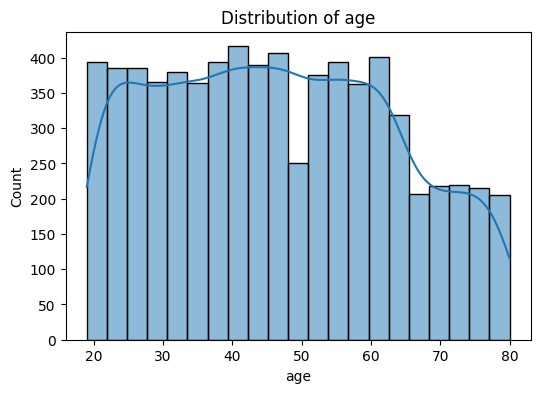

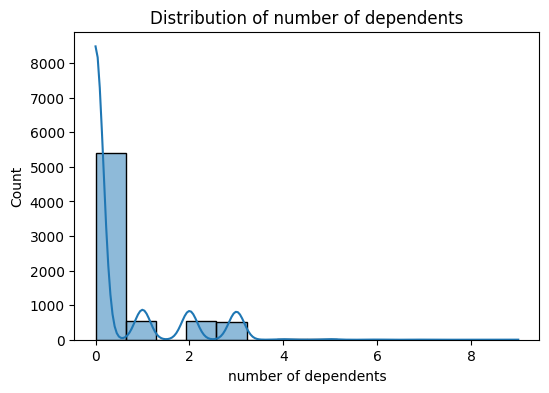

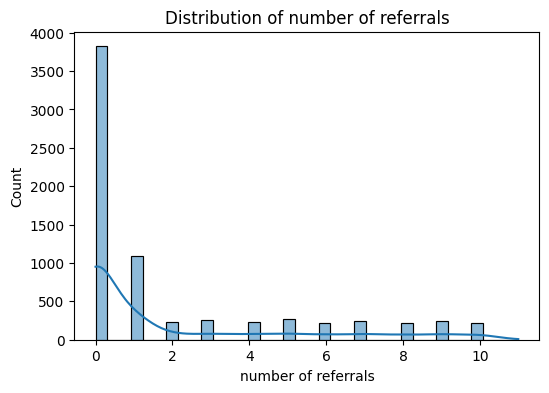

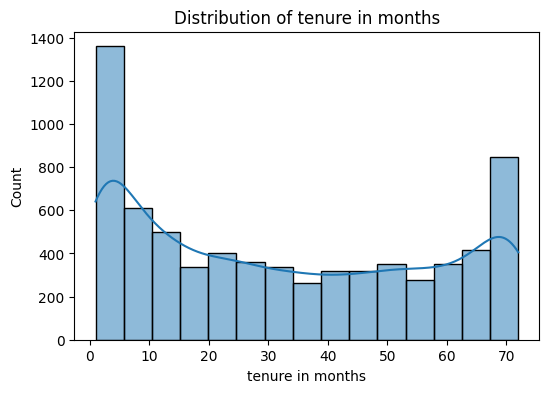

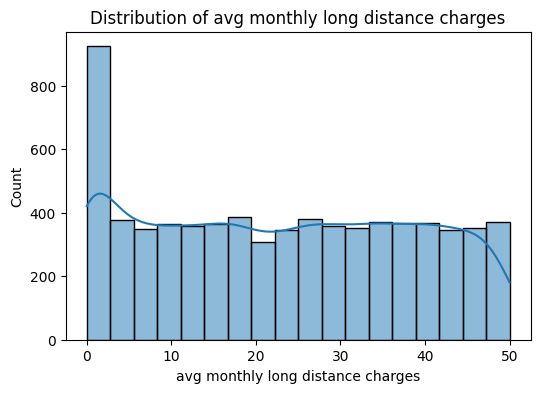

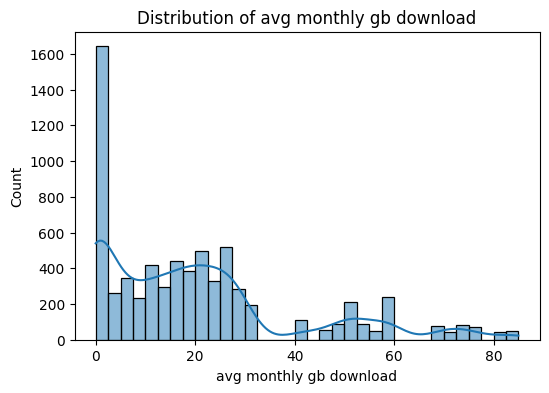

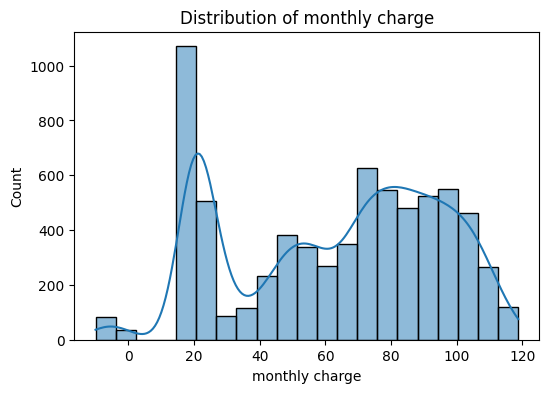

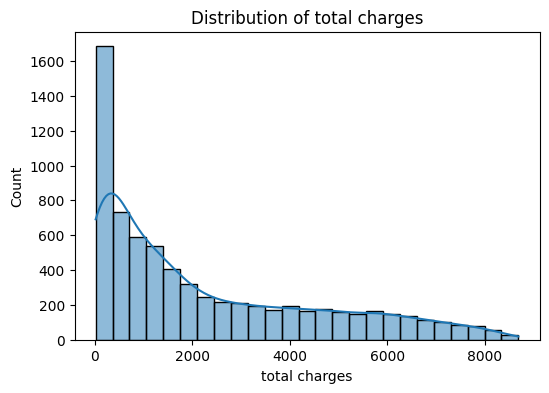

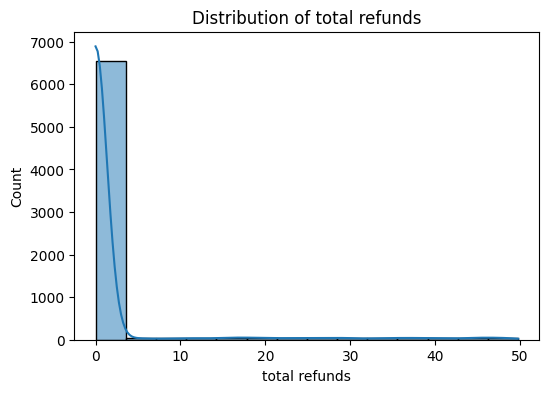

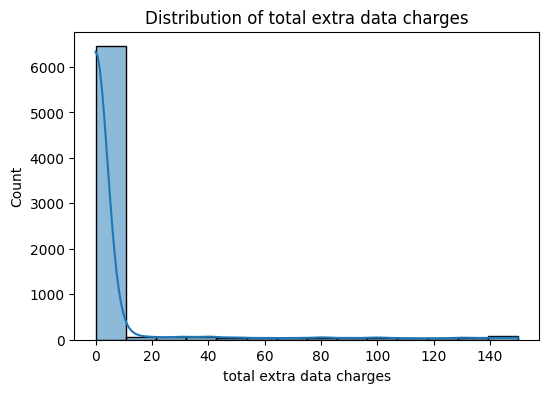

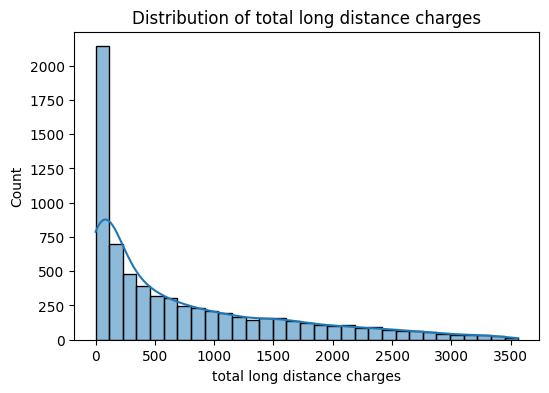

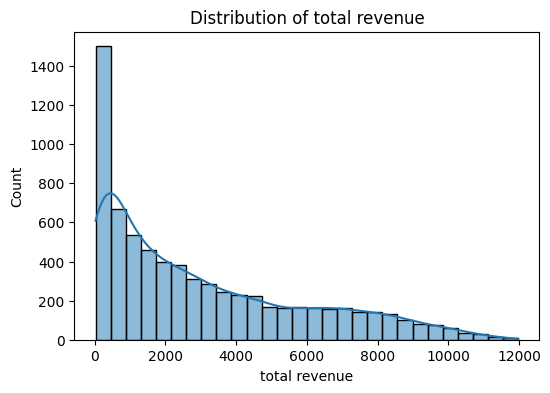

In [ ]:
for col in metric_vars:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

**Distribution of `age`**

The distribution of `age` is relatively uniform across adult age ranges, with customers spanning from young adults to seniors. There is no strong skew, indicating a broadly representative `age` distribution within the customer base.


**Distribution of `number of dependents`**

The variable `number of dependents` is highly right-skewed, with most customers having zero dependents. Higher `numbers of dependents` are increasingly rare, indicating that large households represent a small fraction of the dataset.


**Distribution of `number of referrals`**

`number of referrals` shows a strong right-skew, with the majority of customers making no referrals. A small subset of customers accounts for higher referral counts, suggesting referrals are driven by a limited group of highly engaged users.


**Distribution of `tenure in months`**

The distribution of `tenure in months` shows higher concentration at both lower and higher ends, indicating the presence of both new customers and long-tenured customers. This suggests churn and retention dynamics vary across different tenure stages.


**Distribution of `avg monthly long distance charges`**

`avg monthly long distance charges` displays a broad distribution with higher density at lower values. This suggests that while many customers incur minimal long-distance charges, a subset consistently generates higher long-distance usage.


**Distribution of `avg monthly gb download`**

The distribution of `avg monthly gb download` is right-skewed, with many customers exhibiting low to moderate usage and a smaller group consuming significantly higher data volumes. This indicates heterogeneous internet usage behavior.


**Distribution of `monthly charge`**

`monthly charge` shows a multi-modal distribution, suggesting the presence of different pricing tiers or service bundles. A small number of low or negative values likely reflect billing credits or adjustments.


**Distribution of `total charges`**

The variable `total charges` is strongly right-skewed, with most customers accumulating relatively low lifetime charges and a long tail of high-value customers, likely driven by longer tenure and higher monthly costs.


**Distribution of `total refunds`**

`total refunds` is heavily right-skewed, with most customers receiving little to no refunds. Larger refund amounts occur infrequently and may correspond to service issues or account adjustments.


**Distribution of `total extra data charges`**

The distribution of `total extra data charges` is concentrated near zero, indicating that most customers do not frequently exceed their data limits. Higher extra charges are rare but present, suggesting occasional overage behavior.


**Distribution of `total long distance charges`**

`total long distance charges` exhibits a long right tail, with most customers generating low cumulative charges and a smaller group contributing significantly higher long-distance spending over time.


**Distribution of `total revenue`**

The `total revenue` distribution is right-skewed, with the majority of customers contributing modest revenue and a long tail of high-value customers. This highlights substantial variation in customer lifetime value.

Boxplots for Numerical Outliers

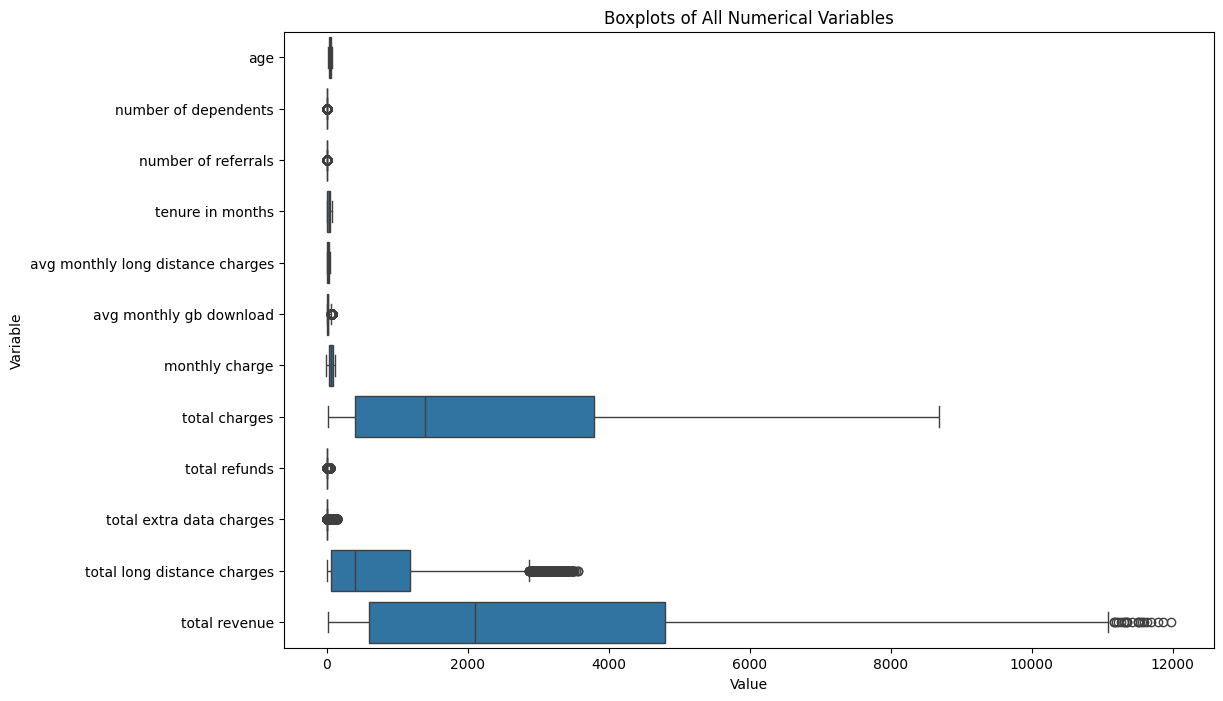

In [ ]:
numerical_vars_for_boxplot = metric_vars

# Melt only metric (continuous numeric) variables
boxplot_df = df[numerical_vars_for_boxplot].melt(
    var_name="Variable",
    value_name="Value"
)
# Create a single plot with all boxplots stacked vertically
plt.figure(figsize=(12, 8))
sns.boxplot(x='Value', y='Variable', data=boxplot_df, orient='h')
plt.title("Boxplots of All Numerical Variables")
plt.xlabel("Value")
plt.ylabel("Variable")
plt.show()

Boxplots were generated for all continuous numerical features (metric_vars) to assess spread, skewness, and potential outliers. Overall, several variables show strong right-skew and visible outliers, especially `total revenue`, `total charges`, and `total long distance charges`, indicating a small group of high-value customers. In contrast, variables such as `age` and `tenure in months` appear more bounded with fewer extreme values. Refund- and overage-related variables (`total refunds` and `total extra data charges`) are concentrated near zero with occasional high outliers, suggesting that most customers rarely receive refunds or incur extra data charges.

Boxplot with scalated variables

In [ ]:
numerical_vars_for_scaling = metric_vars

# Create another dataset for modeling (with scaling)
df_model = df.copy()

# Standardize the copied data set

scaler = StandardScaler()
df_model[numerical_vars_for_scaling] = scaler.fit_transform(df_model[numerical_vars_for_scaling])

All continuous numerical variables (metric_vars) were standardized prior to modeling to ensure they are on a comparable scale. Standardization was performed by subtracting the mean and dividing by the standard deviation for each feature.

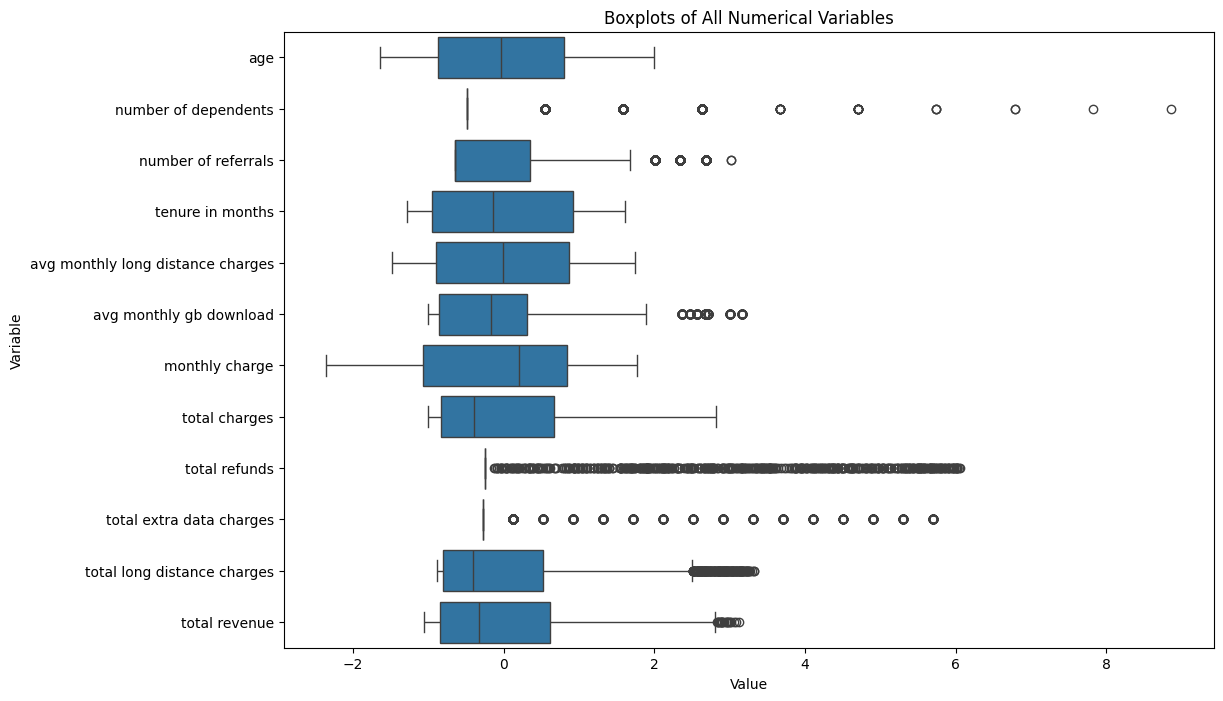

In [ ]:
boxplot_df_model = df_model[numerical_vars_for_scaling].melt( var_name='Variable', value_name='Value' )

# Create a single plot with all boxplots stacked vertaically
plt.figure(figsize=(12, 8))
sns.boxplot(x='Value', y='Variable', data=boxplot_df_model, orient='h')
plt.title("Boxplots of All Numerical Variables")
plt.xlabel("Value")
plt.ylabel("Variable")
plt.show()

After standardization, all numerical variables are centered around zero with comparable spreads, confirming that scaling was applied correctly. Differences in magnitude across features have been removed, allowing distributions to be directly compared.

Variables such as `total revenue`, `total charges`, and `total long distance charges` still exhibit noticeable right-tail outliers, indicating genuine high-value customers rather than scaling artifacts. In contrast, variables like `age` and `tenure in months` appear more symmetrically distributed with fewer extreme values.

Refund- and overage-related features (`total refunds` and `total extra data charges`) remain highly skewed, with most observations near zero and a small number of large standardized values.

Distribution of Binary & Categorical Variables


In [ ]:
categorical_vars_for_freq = binary_vars + binarynu_vars + categorical_vars

for col in categorical_vars_for_freq:
    freq_table = (
        df_model[col]
        .value_counts(dropna=False)
        .to_frame("Absolute")
        .assign(
            Relative=lambda x: round((x["Absolute"] / len(df_model)) * 100, 2)
        )
    )

    print(f"\n=== {col} ===")
    display(freq_table)


=== gender ===


,Absolute,Relative
gender,,
Male,3555,50.48
Female,3488,49.52



=== married ===


,Absolute,Relative
married,,
0,3641,51.7
1,3402,48.3



=== phone service ===


,Absolute,Relative
phone service,,
1,6361,90.32
0,682,9.68



=== multiple lines ===


,Absolute,Relative
multiple lines,,
0,4072,57.82
1,2971,42.18



=== internet service ===


,Absolute,Relative
internet service,,
1,5517,78.33
0,1526,21.67



=== online security ===


,Absolute,Relative
online security,,
0,5024,71.33
1,2019,28.67



=== online backup ===


,Absolute,Relative
online backup,,
0,4614,65.51
1,2429,34.49



=== device protection plan ===


,Absolute,Relative
device protection plan,,
0,4621,65.61
1,2422,34.39



=== premium tech support ===


,Absolute,Relative
premium tech support,,
0,4999,70.98
1,2044,29.02



=== streaming tv ===


,Absolute,Relative
streaming tv,,
0,4336,61.56
1,2707,38.44



=== streaming movies ===


,Absolute,Relative
streaming movies,,
0,4311,61.21
1,2732,38.79



=== streaming music ===


,Absolute,Relative
streaming music,,
0,4555,64.67
1,2488,35.33



=== unlimited data ===


,Absolute,Relative
unlimited data,,
1,4745,67.37
0,2298,32.63



=== paperless billing ===


,Absolute,Relative
paperless billing,,
1,4171,59.22
0,2872,40.78



=== churned ===


,Absolute,Relative
churned,,
0,5174,73.46
1,1869,26.54



=== city ===


,Absolute,Relative
city,,
Los Angeles,293,4.16
San Diego,285,4.05
San Jose,112,1.59
Sacramento,108,1.53
San Francisco,104,1.48
...,...,...
Eldridge,2,0.03
Holtville,2,0.03
Johannesburg,2,0.03



=== offer ===


,Absolute,Relative
offer,,
NaN,3877,55.05
Offer B,824,11.70
Offer E,805,11.43
Offer D,602,8.55
Offer A,520,7.38
Offer C,415,5.89



=== internet type ===


,Absolute,Relative
internet type,,
Fiber Optic,3035,43.09
DSL,1652,23.46
No,1526,21.67
Cable,830,11.78



=== contract ===


,Absolute,Relative
contract,,
Month-to-Month,3610,51.26
Two Year,1883,26.74
One Year,1550,22.01



=== payment method ===


,Absolute,Relative
payment method,,
Bank Withdrawal,3909,55.50
Credit Card,2749,39.03
Mailed Check,385,5.47



=== customer status ===


,Absolute,Relative
customer status,,
Stayed,4720,67.02
Churned,1869,26.54
Joined,454,6.45



=== churn category ===


,Absolute,Relative
churn category,,
NaN,5174,73.46
Competitor,841,11.94
Dissatisfaction,321,4.56
Attitude,314,4.46
Price,211,3.00
Other,182,2.58



=== churn reason ===


,Absolute,Relative
churn reason,,
NaN,5174,73.46
Competitor had better devices,313,4.44
Competitor made better offer,311,4.42
Attitude of support person,220,3.12
Don't know,130,1.85
Competitor offered more data,117,1.66
Competitor offered higher download speeds,100,1.42
Attitude of service provider,94,1.33
Price too high,78,1.11



=== age_group ===


,Absolute,Relative
age_group,,
35-44,1317,18.70
45-54,1286,18.26
55-64,1271,18.05
25-34,1248,17.72
65-80,1142,16.21
18-24,779,11.06


Frequency tables were generated for all categorical and binary variables to examine class distributions and identify potential imbalance. This analysis includes variables from binary_vars, binarynu_vars, and categorical_vars.

For each variable, both absolute counts and relative percentages were computed. Relative frequencies were calculated as a percentage of the total number of observations to enable consistent comparison across features.

Q-Q Plots for Numerical Variables

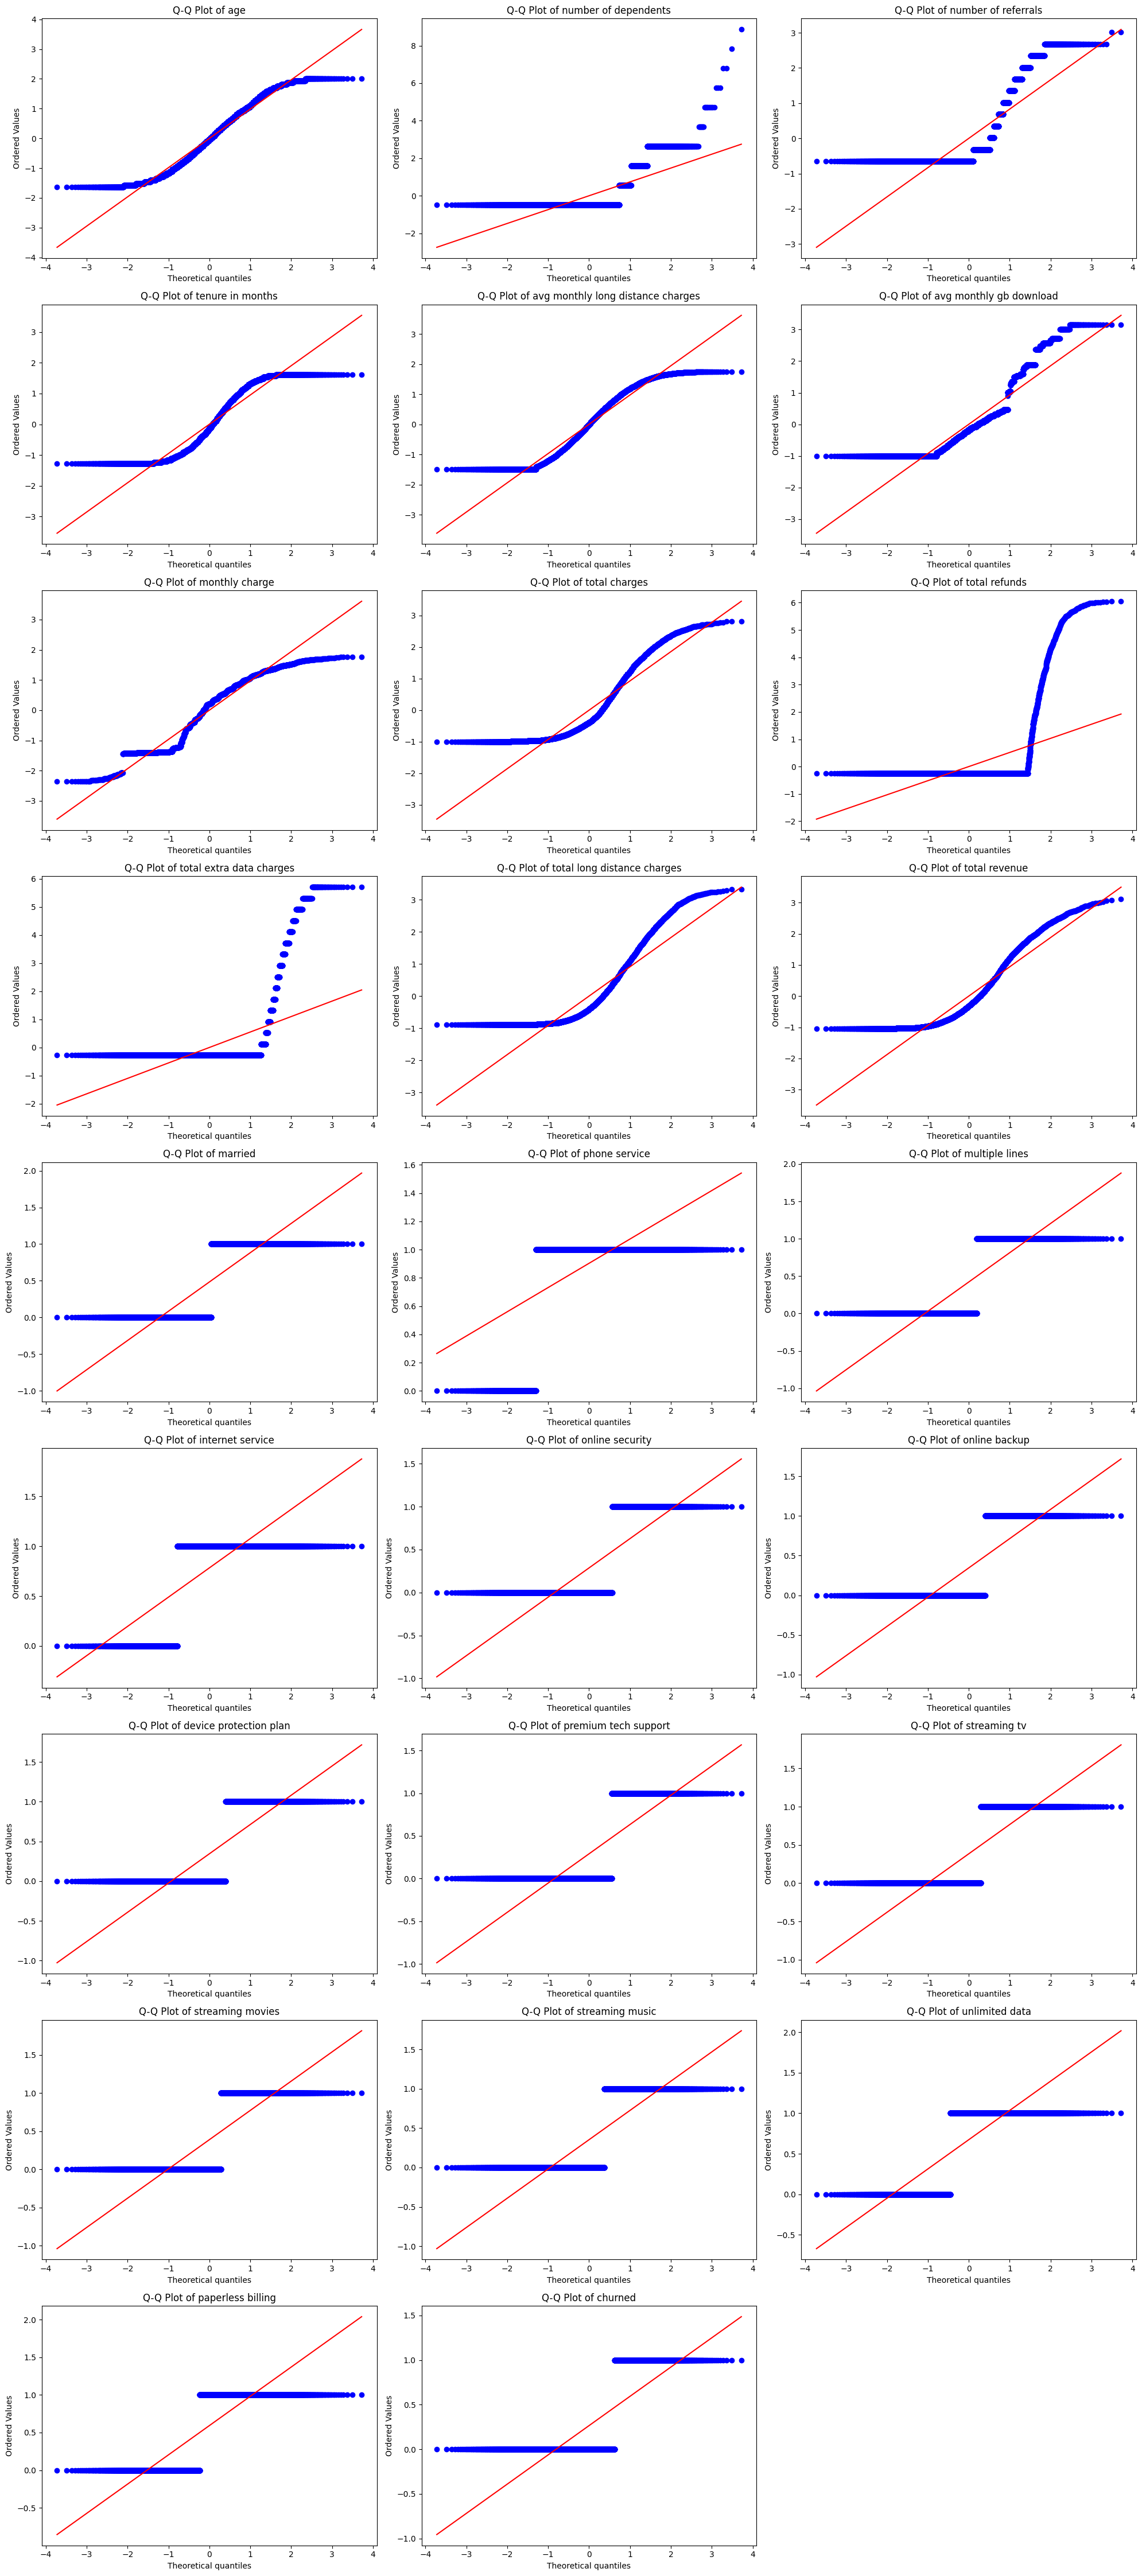

In [ ]:
numerical_vars_for_qq = metric_vars + binarynu_vars


# Create subplot grid
n_vars = len(numerical_vars_for_qq)
n_cols = 3
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(20, n_rows * 5)
)

axes = axes.flatten()

# Loop through variables and create Q-Q plots
for i, var in enumerate(numerical_vars_for_qq):
    stats.probplot(
        df_model[var].dropna(),
        dist="norm",
        plot=axes[i]
    )
    axes[i].set_title(f"Q-Q Plot of {var}")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Q–Q plots were generated for all numerical variables, including continuous features (metric_vars) and numeric binary variables (binarynu_vars), to assess their conformity to a normal distribution after scaling.

###Q-Q Plot by Variable
**Q-Q Plot for `age`**
The distribution of age is approximately normal in the center but deviates at the tails, indicating mild skewness and bounded values at younger and older ages.

**Q-Q Plot for `number of dependents`**

number of dependents shows strong deviation from normality with a step-like pattern, reflecting its discrete and highly right-skewed nature.

**Q-Q Plot for `number of referrals`**

The Q–Q plot for number of referrals indicates significant right skew and discreteness, with most customers having few or no referrals.

**Q-Q Plot for `tenure in months`**

tenure in months roughly follows a symmetric distribution in the center but deviates at the extremes, suggesting mild non-normality and bounded tenure limits.

**Q-Q Plot for `avg monthly long distance charges`**

This variable shows noticeable curvature away from the reference line, indicating skewness and non-normal behavior driven by lower usage concentration.

**Q-Q Plot for `avg monthly gb download`**

The distribution of avg monthly gb download deviates from normality with a right-heavy tail, reflecting a subset of high-usage customers.

**Q-Q Plot for `monthly charge`**

monthly charge exhibits moderate deviations from normality, likely due to pricing tiers and bundled service structures.

**Q-Q Plot for `total charges`**

The Q–Q plot for total charges shows strong right-tail deviation, indicating substantial skewness driven by long-tenured or high-paying customers.

**Q-Q Plot for `total refunds`**

total refunds displays extreme deviation from normality, with most values clustered near zero and a small number of large refund amounts.

**Q-Q Plot for `total extra data charges`**

This variable is highly non-normal, with heavy right skew and a large concentration of zero or near-zero values.

**Q-Q Plot for `total long distance charges`**

total long distance charges shows a pronounced right tail, indicating cumulative effects of sustained long-distance usage by a subset of customers.

**Q-Q Plot for `total revenue`**

The Q–Q plot for total revenue demonstrates strong right-skewness, consistent with a small group of high-lifetime-value customers.

### Q-Q Plots for Binary Variables

**Q-Q Plot for `married`**

The Q–Q plot shows a clear step pattern, confirming that married is binary and not normally distributed.

**Q-Q Plot for `phone service`**

phone service displays a binary structure with no alignment to normality, as expected for a service indicator.

**Q-Q Plot for `multiple lines`**

The discrete two-level nature of multiple lines produces a step-like Q–Q plot, confirming non-normality.

**Q-Q Plot for `internet service`**

internet service exhibits a binary distribution with strong deviation from the reference line, as expected.

**Q-Q Plot for `online security`**

The Q–Q plot reflects a binary indicator with no normal distribution characteristics.

**Q-Q Plot for `online backup`**

online backup shows a discrete binary pattern, confirming non-normal behavior.

**Q-Q Plot for `device protection plan`**

This variable displays a clear binary structure and does not follow a normal distribution.

**Q-Q Plot for `premium tech support`**

The Q–Q plot confirms that premium tech support is binary and highly non-normal.

**Q-Q Plot for `streaming tv`**

streaming tv shows a binary, step-wise pattern consistent with a yes/no service indicator.

**Q-Q Plot for `streaming movies`**

The distribution of streaming movies is binary and deviates fully from normality.

**Q-Q Plot for `streaming music`**

streaming music exhibits a discrete binary pattern with no normal characteristics.

**Q-Q Plot for `unlimited data`**

The Q–Q plot confirms unlimited data is binary and non-normally distributed.

**Q-Q Plot for `paperless billing`**

paperless billing shows a binary distribution with a step-like Q–Q pattern.

**Q-Q Plot for `churned`**

The target variable churned is binary and displays expected non-normal behavior.

### 1.3 Target Variable Analysis

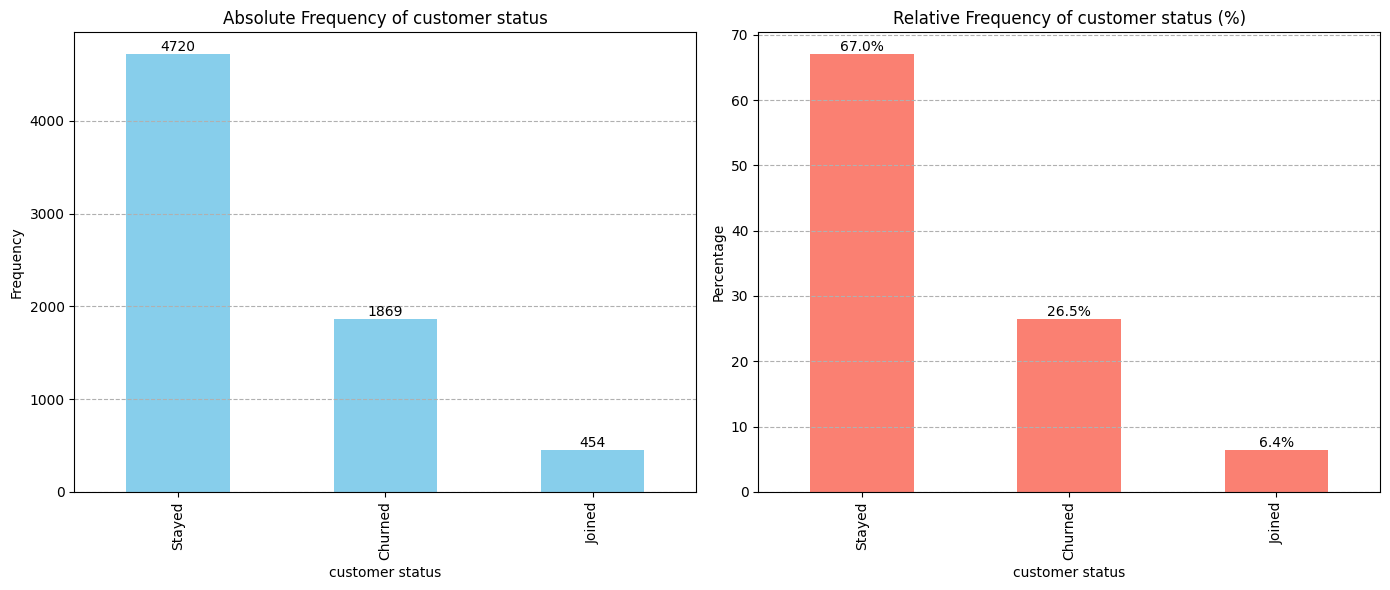

In [ ]:
# Function to plot absolute and relative frequency for a given variable
def plot_frequency(variable, title):
    # Calculate absolute frequency
    abs_freq = df[variable].value_counts()

    # Calculate relative frequency
    rel_freq = df[variable].value_counts(normalize=True) * 100

    # Plotting
    plt.figure(figsize=(14, 6))

    # Absolute frequency
    plt.subplot(1, 2, 1)
    bars_abs = abs_freq.plot(kind='bar', color='skyblue')
    plt.title(f'Absolute Frequency of {title}')
    plt.xlabel(title)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--')
    plt.bar_label(bars_abs.containers[0])


    # Relative frequency
    plt.subplot(1, 2, 2)
    bars_rel = rel_freq.plot(kind='bar', color='salmon')
    plt.title(f'Relative Frequency of {title} (%)')
    plt.xlabel(title)
    plt.ylabel('Percentage')
    plt.grid(axis='y', linestyle='--')
    plt.bar_label(bars_rel.containers[0],fmt="%.1f%%")


    plt.tight_layout()
    plt.show()

# Plotting for Customer status
plot_frequency('customer status', 'customer status')

Distribution of `customer status`

The distribution of `customer status` shows that the majority of customers have stayed, accounting for approximately 67.0% of the dataset. Customers who have churned represent around 26.5%, while joined customers make up a smaller share at approximately 6.4%.

This indicates a clear class imbalance, with retained customers forming the dominant group. The presence of a substantial churned segment highlights the importance of understanding drivers of customer attrition, while the relatively small proportion of newly joined customers suggests limited recent acquisition relative to the overall customer base.

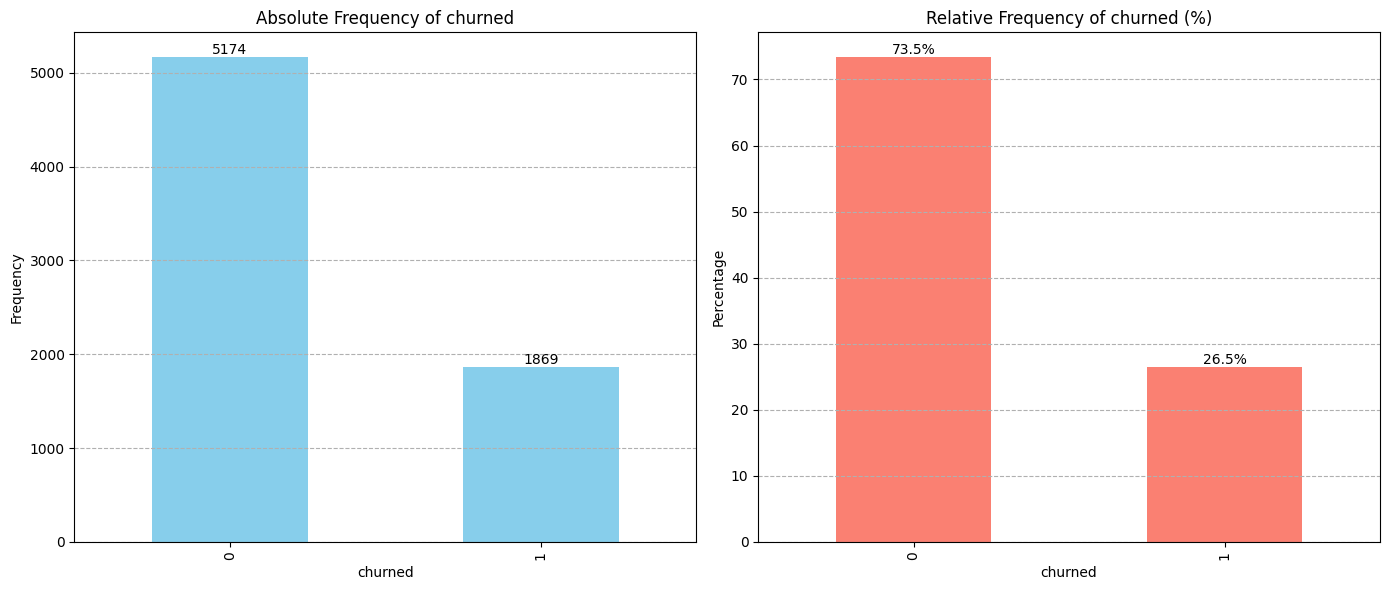

In [ ]:
# Function to plot absolute and relative frequency for a given variable
def plot_frequency(variable, title):
    # Calculate absolute frequency
    abs_freq = df[variable].value_counts()

    # Calculate relative frequency
    rel_freq = df[variable].value_counts(normalize=True) * 100

    # Plotting
    plt.figure(figsize=(14, 6))

    # Absolute frequency
    plt.subplot(1, 2, 1)
    bars_abs = abs_freq.plot(kind='bar', color='skyblue')
    plt.title(f'Absolute Frequency of {title}')
    plt.xlabel(title)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--')
    plt.bar_label(bars_abs.containers[0])


    # Relative frequency
    plt.subplot(1, 2, 2)
    bars_rel = rel_freq.plot(kind='bar', color='salmon')
    plt.title(f'Relative Frequency of {title} (%)')
    plt.xlabel(title)
    plt.ylabel('Percentage')
    plt.grid(axis='y', linestyle='--')
    plt.bar_label(bars_rel.containers[0],fmt="%.1f%%")


    plt.tight_layout()
    plt.show()

# Plotting for Customer status
plot_frequency('churned', 'churned')

The target variable `churned` shows that the majority of customers did not churn (0), representing approximately 73.5% of the dataset. Customers who churned (1) account for about 26.5% of observations.

This confirms a moderate class imbalance, with non-churned customers forming the dominant group. However, the proportion of churned customers is still substantial, making churn prediction both feasible and meaningful.

/tmp/ipython-input-562/1879109938.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_counts = df.groupby(col)["churned"].sum().sort_values(ascending=False)


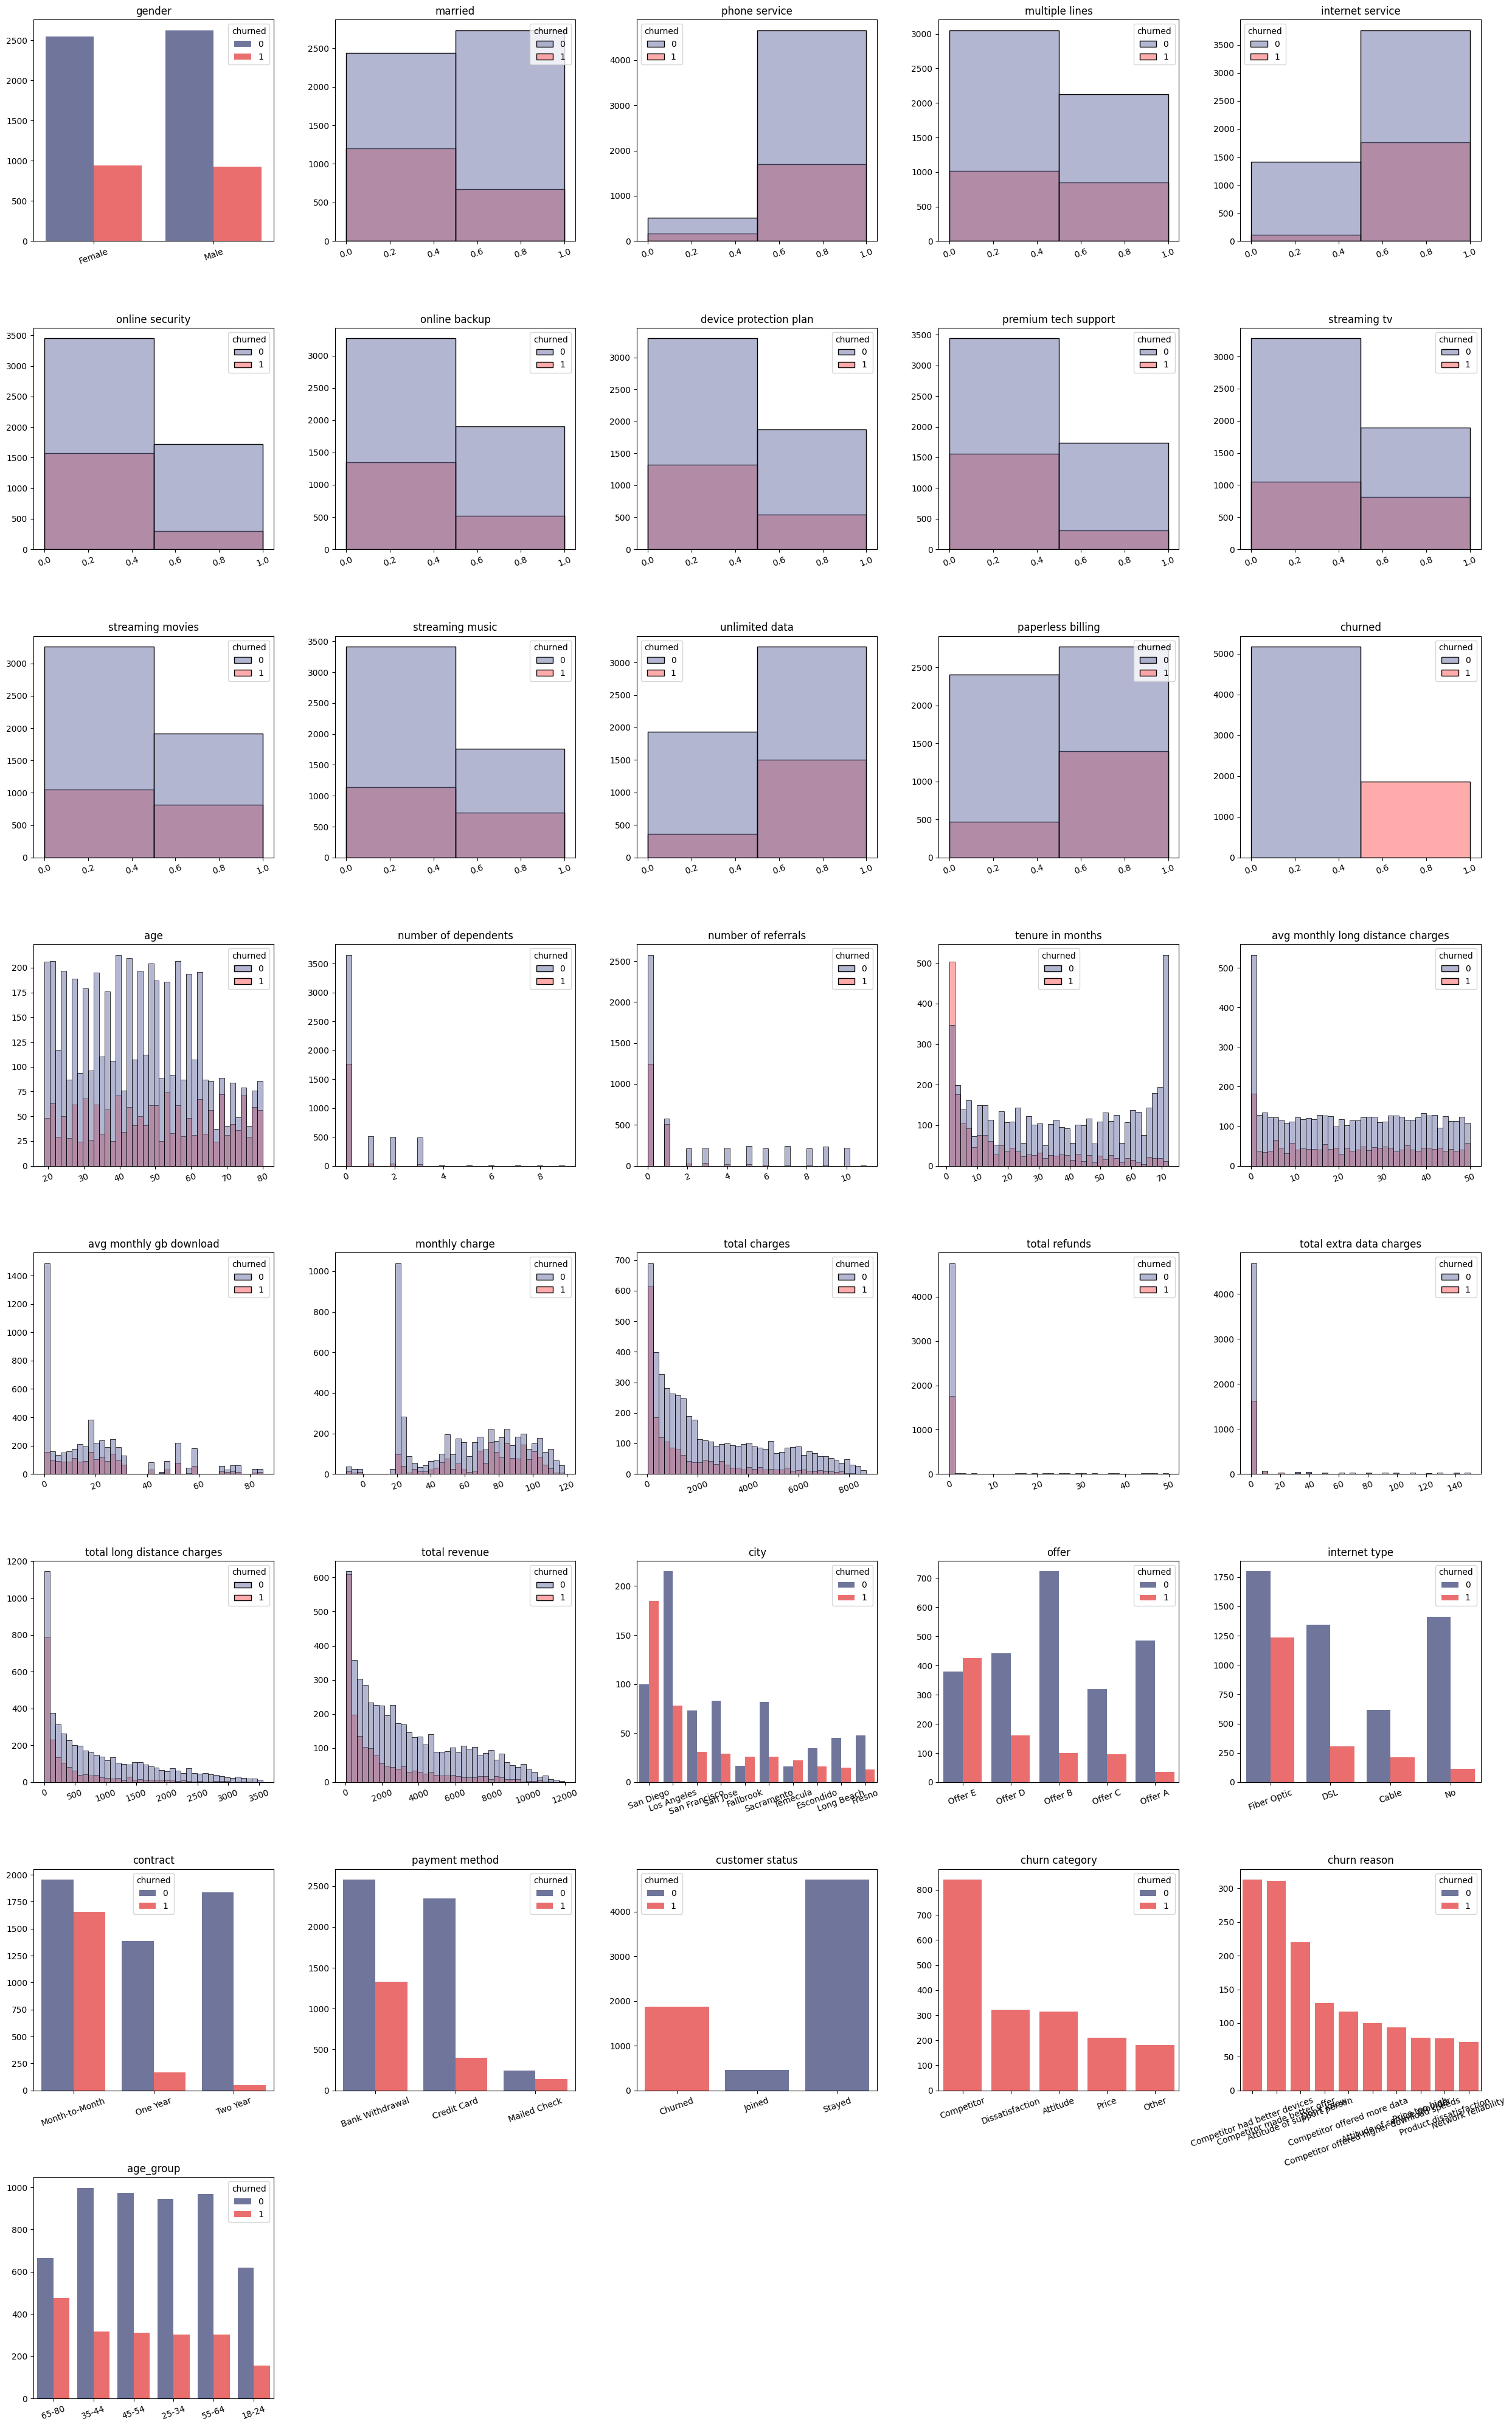

In [ ]:
num = binary_vars + binarynu_vars + metric_vars + categorical_vars

nplots = len(num)
ncols = 5
nrows = math.ceil(nplots / ncols)

fig = plt.figure(figsize=(25, 5 * nrows))

i = 1
for col in num:
    ax = plt.subplot(nrows, ncols, i)

    # Decide if categorical (object/category) vs numeric
    if (col in categorical_vars) or (df[col].dtype == "object") or (str(df[col].dtype) == "category"):
        # Order by churned==1 count, but include all categories (top 10 optional)
        churn_counts = df.groupby(col)["churned"].sum().sort_values(ascending=False)
        order = churn_counts.index.tolist()[:10]  # <- top 10 by churned==1

        sns.countplot(
            data=df,
            x=col,
            hue="churned",
            order=order,
            palette=['#676FA3', '#FF5959'],
            ax=ax
        )
        ax.tick_params(axis="x", rotation=20, labelsize=10)

    else:
        # bins: binary -> 2, else 40
        bins = 2 if df[col].nunique(dropna=False) <= 2 else 40

        sns.histplot(
            data=df,
            x=col,
            hue="churned",
            palette=['#676FA3', '#FF5959'],
            bins=bins,
            ax=ax
        )
        ax.tick_params(axis="x", rotation=20, labelsize=10)

    ax.set(xlabel=None, ylabel=None)
    ax.set_title(str(col), loc="center")
    i += 1

# Remove empty axes if grid has extra slots (e.g., 30 slots for 26 plots)
for j in range(i, nrows * ncols + 1):
    fig.add_subplot(nrows, ncols, j).axis("off")

plt.tight_layout()
plt.show()

### **`churn` vs key features**

**Absolute Frequency of `gender`**

Churn counts appear broadly similar across genders, suggesting gender alone may not be a strong churn separator.

**Absolute Frequency of `married`***

The churn distribution differs between married = 0 and married = 1, indicating marital status may relate to churn behavior and is worth testing via churn rates.

**Absolute Frequency of `phone service`**

Most customers have phone service = 1, and churn occurs primarily within this dominant group. The difference is driven largely by base population size, so churn rate comparison is recommended.

**Absolute Frequency of `multiple lines`**

Both multiple lines = 0 and multiple lines = 1 show churn activity, with no extreme imbalance visually; this feature may contribute modest signal.

**Absolute Frequency of `internet service`**

Churn is concentrated among customers with internet service = 1 (the larger group), suggesting internet subscribers are the primary churn population in this dataset.

**Absolute Frequency of `online security`**

Customers without online security (0) show visibly higher churn counts than those with online security = 1, suggesting this add-on may be associated with retention.

**Absolute Frequency of `online backup`**

A similar pattern is observed for online backup: churn appears higher among customers without the service, indicating potential retention value.

**Absolute Frequency of `device protection plan`**

Churn is more prominent for device protection plan = 0 compared to 1, suggesting customers with protection plans may be more stable.

**Absolute Frequency of `premium tech support`**

Customers without premium tech support (0) show substantially more churn than those with the service, indicating this feature may be a strong retention correlate.

**Absolute Frequency of `streaming tv`**

Churn appears across both groups, but slightly higher among streaming tv = 0 in absolute count; churn rate should confirm whether streaming adoption reduces churn.

**Absolute Frequency of `streaming movies`**

Both categories show churn, with no sharp split visually; this may be a weaker signal compared to support/security add-ons.

**Absolute Frequency of `streaming music`**

Churn appears somewhat higher for streaming music = 0 than 1 in counts, again suggesting a possible (but not definitive) association.

**Absolute Frequency of `unlimited data`**

Churn is substantial in unlimited data = 1 because the group is large; churn rates are needed to assess whether unlimited data increases or decreases churn risk.

**Absolute Frequency of `aperless billing`**

paperless billing shows noticeable churn in both groups; visual separation is not extreme, but it may interact with billing/payment behaviors.

**Absolute Frequency of `churned`**

The target is moderately imbalanced, with more churned = 0 than churned = 1, consistent with earlier frequency plots.

###**churn vs numeric distributions**

**Absolute Frequency of `age`**

The churn distribution spans the full age range with no single dominant age band; any age effect likely requires aggregation (e.g., age_group) or churn-rate comparisons.

**Absolute Frequency of `number of dependents`**

Most customers have number of dependents = 0, and churn is concentrated there. Higher dependent counts are rare, so their churn interpretation should be rate-based.

**Absolute Frequency of `number of referrals`**

Churn is heavily concentrated at number of referrals = 0, while customers with referrals appear less common and may churn less frequently (needs rate check).

**Absolute Frequency of `tenure in months`**

Churn appears more concentrated at lower tenure in months, while longer-tenured customers skew toward non-churn, suggesting tenure is a strong churn driver.

**Absolute Frequency of `avg monthly long distance charges`**

Churn occurs across the range of avg monthly long distance charges with no sharp cutoff; this feature may be weaker alone but could contribute in combination with other usage metrics.

**Absolute Frequency of `avg monthly gb download`**

Churn is present across usage levels, with heavier concentration at low-to-moderate values; usage may be informative but not linearly related.

**Absolute Frequency of `monthly charge`**

The churn distribution spans multiple pricing tiers, implying churn may depend on plan type/bundle rather than a single monotonic relationship with monthly charge.

**Absolute Frequency of `total charges`**

Customers with lower total charges show more churn (consistent with shorter tenure), while higher total charges skew more toward non-churn.

**Absolute Frequency of `total refunds`**

Most values cluster near zero; churn exists at low refunds and also among a smaller set with higher refunds, suggesting refunds may reflect service/billing friction.

**Absolute Frequency of `total extra data charges`**

Most customers have near-zero total extra data charges; churn appears mainly in the near-zero region due to volume, with a thin tail of higher-charge customers.

**Absolute Frequency of `total long distance charges`**

Right-skewed distribution with churn concentrated at lower totals; high cumulative long-distance spenders are fewer and appear more often non-churned (needs rate validation).

**Absolute Frequency of `total revenue`**

Strong right-skew; churn is more common at lower total revenue, while higher-revenue customers are more often retained, consistent with tenure/value effects.

###churn vs categorical variables
**Absolute Frequency of `city`**

Churn is present across major cities; differences appear to be driven by city size. Churn rate by city is recommended to confirm true geographic variation.

**Absolute Frequency of `offer`**

Certain offer categories show higher churn counts than others, suggesting offers may be linked to retention outcomes (or targeted to high-risk customers). Rate-based comparison is recommended.

**Absolute Frequency of `internet type`**

Churn varies across internet type categories; one category appears to carry a larger churn share. This feature is likely informative and should be tested via churn rates.

**Absolute Frequency of `contract`**

contract shows a strong visual pattern: month-to-month customers churn substantially more than customers on longer contracts (one year, two year), indicating contract length is a key churn driver.

**Absolute Frequency of `payment method`**

Churn differs by payment method, with one method showing noticeably higher churn counts. This suggests payment behavior may be a useful churn predictor.

**Absolute Frequency of `customer status`**

The distribution confirms most customers are stayed, with churned as a sizable minority and joined as a smaller segment.

**Absolute Frequency of `churn category`**

churn category is only meaningful for churned customers and reflects the dominant churn drivers in the dataset (e.g., competitor-related vs dissatisfaction/price). This should not be used for prediction due to leakage.

**Absolute Frequency of `churn reason`**

churn reason further breaks down churn explanations and is also post-outcome information; it is useful for diagnosis but should be excluded from modeling to avoid leakage.

**Absolute Frequency of `age_group`**

Churn is distributed across all age_group segments, with some variation between groups. Churn rates by age_group will clarify whether specific age bands are at higher risk.

Filtering Phone Service Dependent Variables

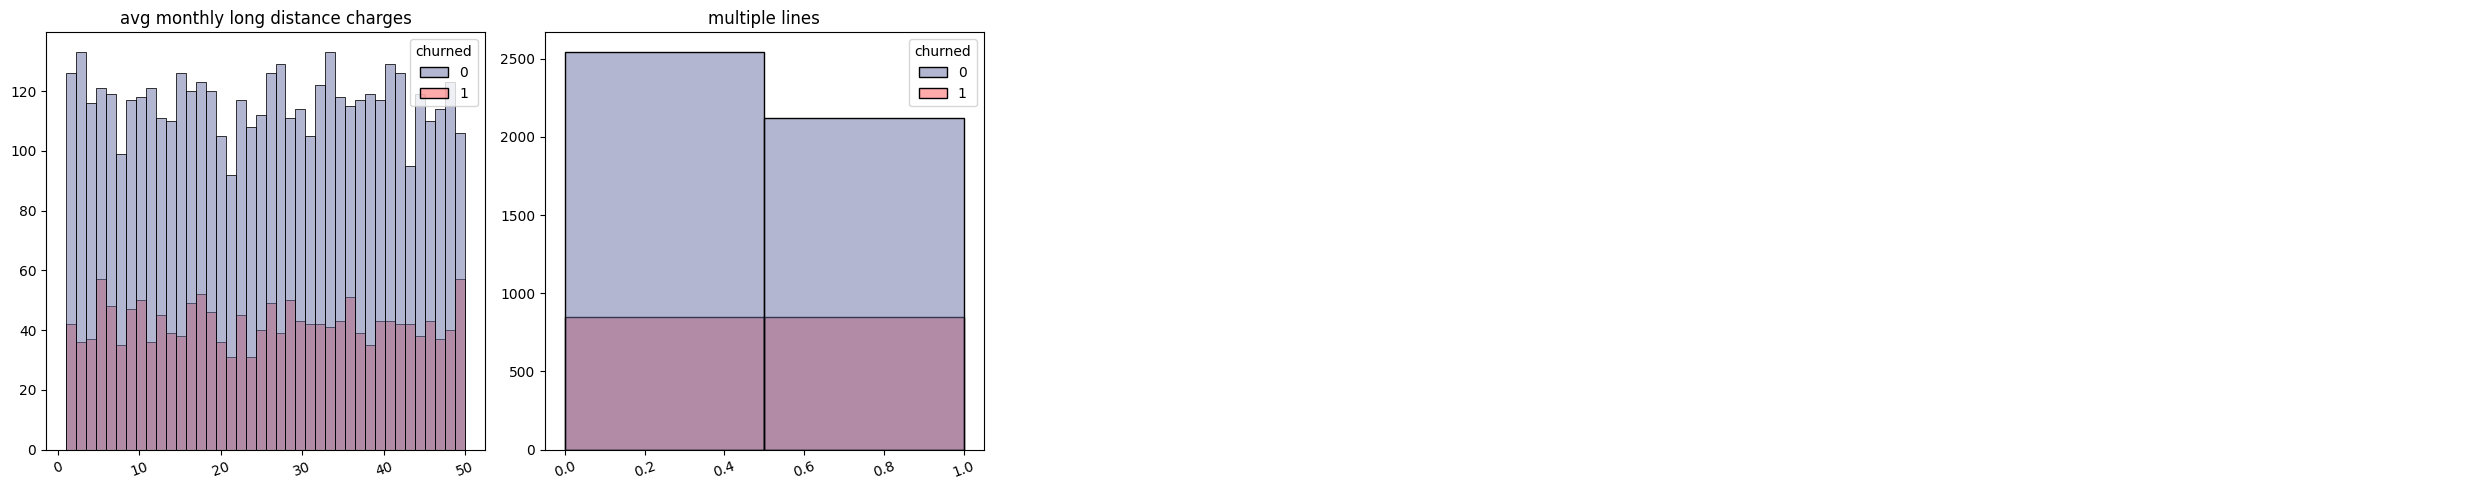

In [ ]:
df_ph = df[df["phone service"] == 1].copy()

num_ph = cols_ph

nplots = len(num_ph)
ncols = 5
nrows = math.ceil(nplots / ncols)

fig = plt.figure(figsize=(25, 5 * nrows))

i = 1
for col in num_ph:
    ax = plt.subplot(nrows, ncols, i)

    # Decide if categorical vs numeric
    if (col in categorical_vars) or (df_ph[col].dtype == "object") or (str(df_ph[col].dtype) == "category"):

        churn_counts = (
            df_ph.groupby(col)["churned"]
            .sum()
            .sort_values(ascending=False)
        )
        order = churn_counts.index.tolist()[:10]

        sns.countplot(
            data=df_ph,
            x=col,
            hue="churned",
            order=order,
            palette=['#676FA3', '#FF5959'],
            ax=ax
        )
        ax.tick_params(axis="x", rotation=20, labelsize=10)

    else:
        bins = 2 if df_ph[col].nunique(dropna=False) <= 2 else 40

        sns.histplot(
            data=df_ph,
            x=col,
            hue="churned",
            palette=['#676FA3', '#FF5959'],
            bins=bins,
            ax=ax
        )
        ax.tick_params(axis="x", rotation=20, labelsize=10)

    ax.set(xlabel=None, ylabel=None)
    ax.set_title(str(col), loc="center")
    i += 1

# Remove empty axes
for j in range(i, nrows * ncols + 1):
    fig.add_subplot(nrows, ncols, j).axis("off")

plt.tight_layout()
plt.show()

To be examined within the appropriate population, providing clearer and more meaningful comparisons of churn-related distributions, he analysis was repeated on a filtered subset of customers who have phone service.

**Absolute Frequency of `avg monthly long distance charges` after filtering**

Before filtering, the histogram of avg monthly long distance charges includes all customers, including those without phone service. This creates a very large spike at values close to 0, because customers without phone service naturally have zero or near-zero long-distance charges. As a result, most of the bars are concentrated at the left side of the plot, which compresses the rest of the distribution and makes it difficult to observe meaningful differences between churned and non-churned customers who actually use the service.

After filtering to only customers with phone service = 1, the zero-charge spike disappears. The distribution now spans the full range of values (roughly 0–50) more evenly. Each bin contains fewer but more relevant observations, allowing us to clearly see how long-distance charges are distributed among customers who actually incur these charges.


**Absolute Frequency of `multiple lines` after filtering**

Before filtering, the distribution of multiple lines includes customers who do not have phone service, which inflates the count of 0 values and makes the churn comparison less informative. After filtering to include only customers with phone service, the distribution becomes more representative of customers for whom the multiple lines variable is meaningful. In this filtered chart, the separation between churned and non-churned customers is clearer, showing a higher concentration of churn among customers without multiple lines compared to those with multiple lines. This suggests that having multiple phone lines is associated with greater customer retention once phone service is present.

Filtering Internet Service Dependent Variables

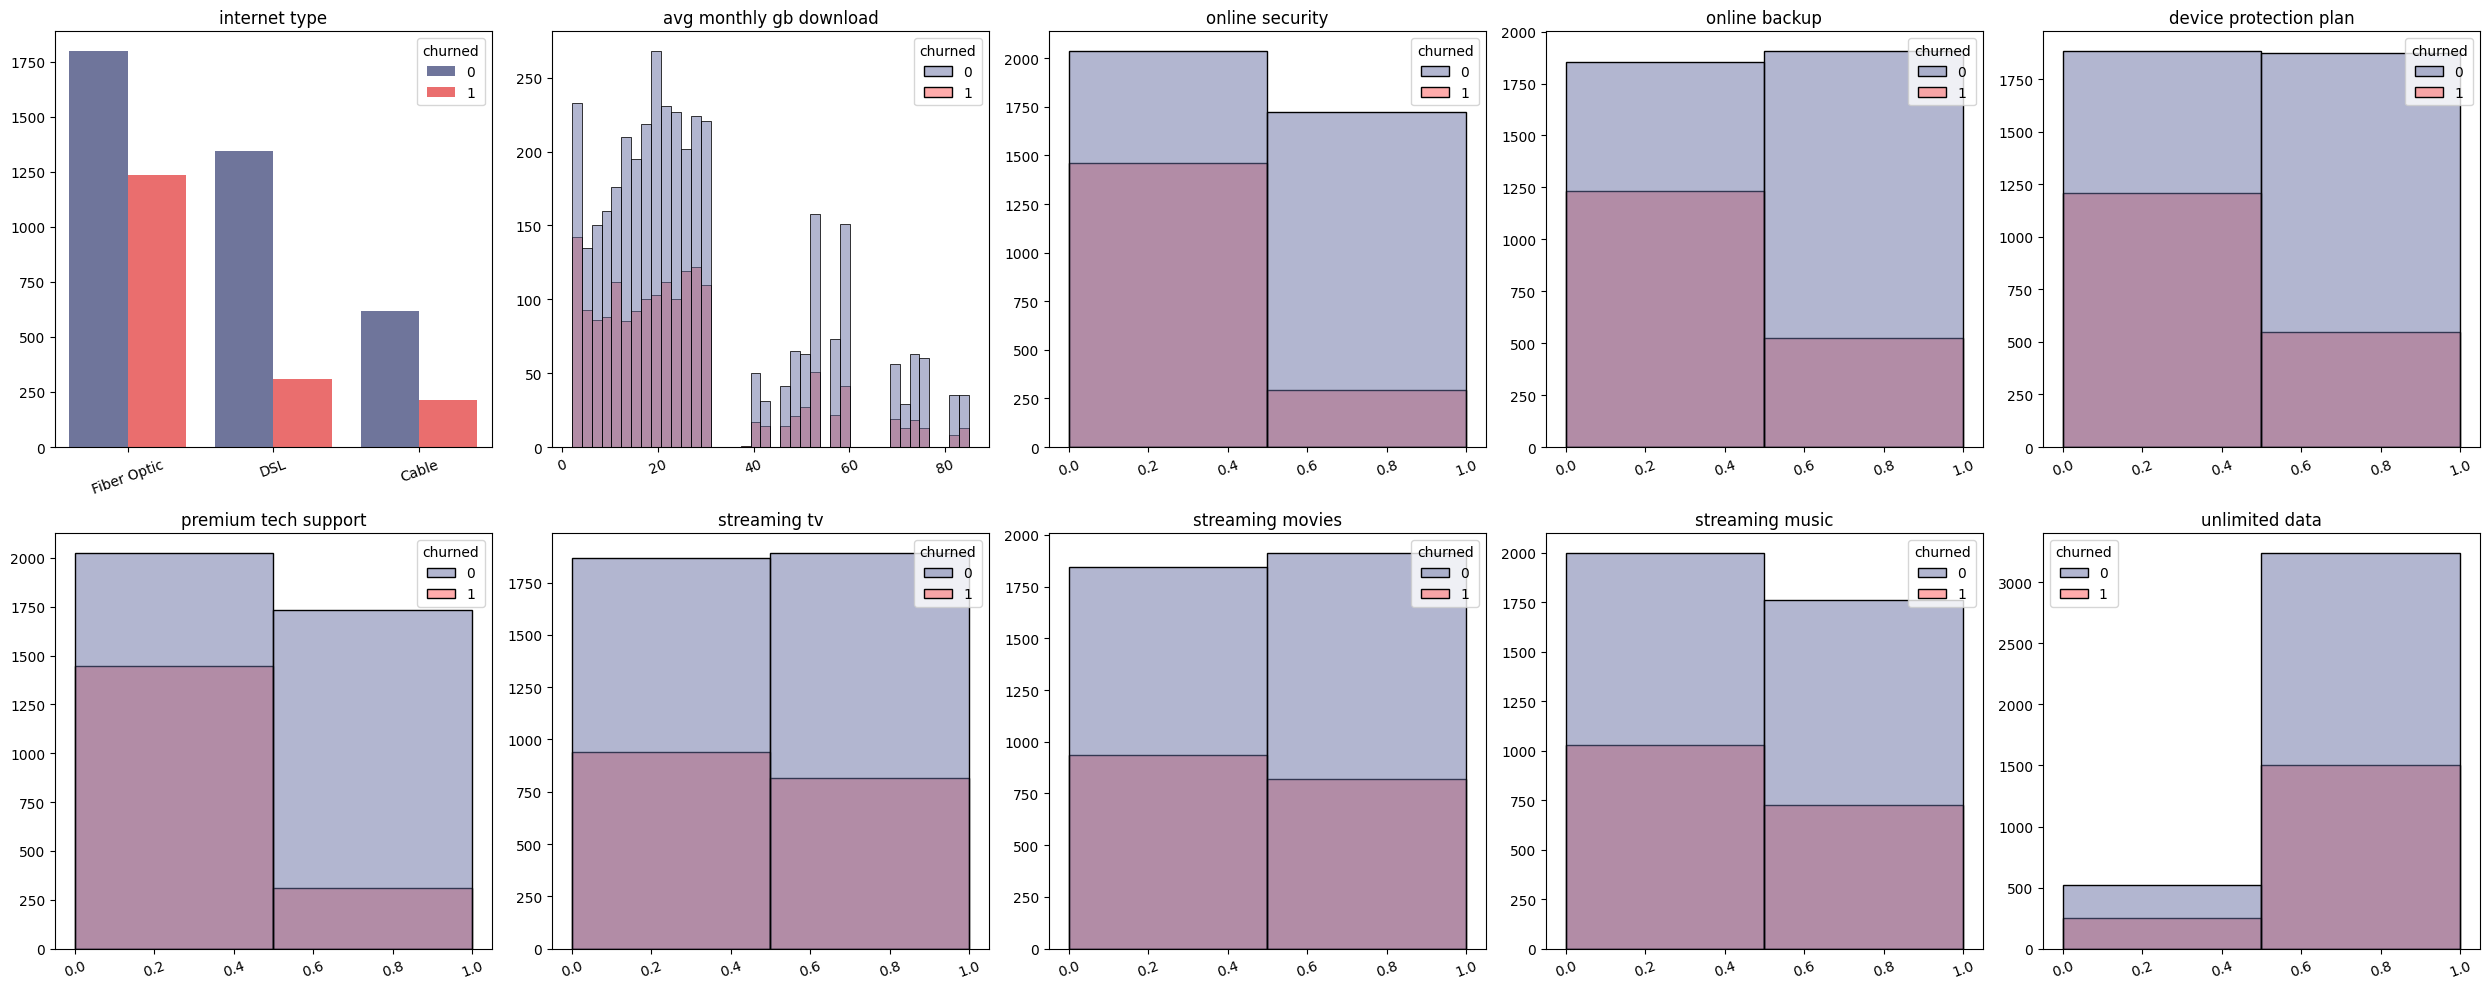

In [ ]:
df_in = df[df["internet service"] == 1].copy()

num_in = cols_in

nplots = len(num_in)
ncols = 5
nrows = math.ceil(nplots / ncols)

fig = plt.figure(figsize=(25, 5 * nrows))

i = 1
for col in num_in:
    ax = plt.subplot(nrows, ncols, i)

    # Decide if categorical vs numeric
    if (col in categorical_vars) or (df_in[col].dtype == "object") or (str(df_in[col].dtype) == "category"):

        churn_counts = (
            df_in.groupby(col)["churned"]
            .sum()
            .sort_values(ascending=False)
        )
        order = churn_counts.index.tolist()[:10]

        sns.countplot(
            data=df_in,
            x=col,
            hue="churned",
            order=order,
            palette=['#676FA3', '#FF5959'],
            ax=ax
        )
        ax.tick_params(axis="x", rotation=20, labelsize=10)

    else:
        bins = 2 if df_in[col].nunique(dropna=False) <= 2 else 40

        sns.histplot(
            data=df_in,
            x=col,
            hue="churned",
            palette=['#676FA3', '#FF5959'],
            bins=bins,
            ax=ax
        )
        ax.tick_params(axis="x", rotation=20, labelsize=10)

    ax.set(xlabel=None, ylabel=None)
    ax.set_title(str(col), loc="center")
    i += 1

# Remove empty axes
for j in range(i, nrows * ncols + 1):
    fig.add_subplot(nrows, ncols, j).axis("off")

plt.tight_layout()
plt.show()

To be examined within the appropriate population, providing clearer and more meaningful comparisons of churn-related distributions, he analysis was repeated on a filtered subset of customers who have internet service.

**Absolute Frequency of `internet type` after filtering**

The chart is same after filtering, since people who don´t have internet service, don´t have any of its type.

**Absolute Frequency of `internet type` after filtering**
Before filtering, the distribution is dominated by a very large spike at 0 GB, which represents customers without internet service. This spike compresses the rest of the histogram, making it hard to see how usage is distributed among actual internet users. After filtering to customers who do have internet service, the zero-usage spike largely disappears, and the distribution spreads across realistic data-consumption ranges. This reveals a much clearer structure: most customers cluster in the low-to-mid usage range (roughly 5–30 GB), with smaller but visible groups of heavier users beyond that. The separation between churned and non-churned customers becomes easier to interpret, especially at higher usage levels where churned customers appear less concentrated.

**Absolute Frequency of `online security` after filtering**

In the filtered chart, churned customers are noticeably more concentrated among those without online security, while customers who stayed are more evenly split or skewed toward having online security (1). This suggests that, among internet users, not having online security is associated with a higher likelihood of churn, whereas having online security appears to be linked with greater customer retention.

**Absolute Frequency of `online backup` after filtering**

Among internet users, customers without online backup are more heavily represented in the churned group, while customers who have online backup appear more frequently among those who stayed. This indicates that online backup is associated with higher retention once eligibility is controlled for, a relationship that was obscured in the unfiltered chart by the presence of customers who could never adopt the service.

**Absolute Frequency of `device protection plan` after filtering**

The total counts decrease, but the relationship sharpens: customers with a device protection plan consistently show lower churn counts relative to non-churned customers than those without the plan. In contrast, customers without device protection remain overrepresented among churned users. This filtered view removes structural noise and clarifies that having a device protection plan is associated with better retention among customers who can actually use the service, strengthening its relevance as a churn-related feature rather than just reflecting overall population imbalance.

**Absolute Frequency of `premium tech support` after filtering**

The after chart shows a clearer pattern: customers with premium tech support are much more concentrated in the non-churned group, while churned customers are predominantly found among those without premium tech support. This shift indicates that, among internet users, premium tech support is associated with lower churn, and the filtering removes noise that previously masked this relationship.

**Absolute Frequency of `streaming tv` after filtering**

In this filtered view, customers without streaming TV show a relatively higher proportion of churn compared to those with streaming TV, while customers who do subscribe to streaming TV are more concentrated among non-churners. This suggests that, among internet users, having streaming TV is associated with greater customer retention, an effect that was partially hidden in the unfiltered chart due to the inclusion of ineligible customers.


**Absolute Frequency of `streaming movies` after filtering**

The comparison between churned and non-churned customers is clearer: customers without streaming movies show a relatively higher presence of churn compared to those with streaming movies, while customers who do have streaming movies are more concentrated in the non-churned group. This suggests that, among internet users, subscribing to streaming movies is associated with higher retention, an effect that was partially hidden in the unfiltered (before) chart.

**Absolute Frequency of `streaming music` after filtering**

Among internet users, churned customers are relatively more concentrated in the “no streaming music” group compared to non-churned customers, while customers who do have streaming music are more likely to stay. This indicates that streaming music is not just a passive add-on but may be linked to higher engagement and lower churn once internet availability is controlled for.


**Absolute Frequency of `unlimited data` after filtering**

In this filtered chart, churned customers are more concentrated in the unlimited data = 1 group, but the proportion of churners relative to non-churners is lower than in the unlimited data = 0 group. This makes the relationship clearer: among internet users, having unlimited data is associated with lower churn risk compared to not having it

Numerical Variables Correlations

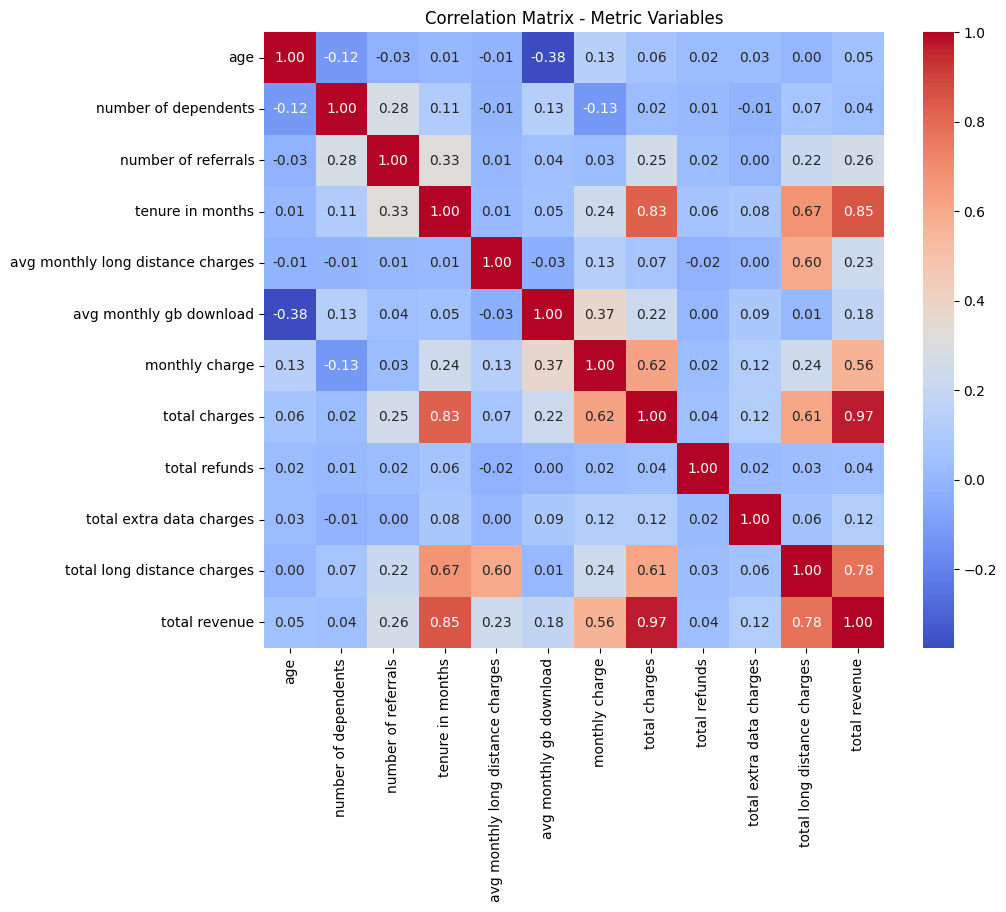

In [ ]:
corr_matrix = df[metric_vars].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix - Metric Variables")
plt.show()

The strongest relationships are driven by tenure and accumulated monetary variables: tenure in months is highly correlated with total charges (0.83), total revenue (0.85), and total long distance charges (0.67), which is expected because customers who stay longer naturally accumulate higher total costs and revenue. Similarly, total charges and total revenue show an extremely strong correlation (0.97), indicating near redundancy and suggesting that keeping both variables in a predictive model could introduce multicollinearity. Monthly-level variables behave differently: monthly charge has a moderate correlation with total charges (0.62) and total revenue (0.56), showing that while higher monthly fees contribute to higher totals, duration still plays a dominant role. Usage-related variables such as avg monthly gb download and avg monthly long distance charges have generally weak correlations with most financial totals, implying that usage intensity alone does not strongly drive overall revenue without tenure. Demographic variables like age and number of dependents exhibit very low correlations with most metrics, suggesting limited linear influence on spending behavior. Overall, the matrix shows that the dataset is structured around a core tenure–revenue axis, with monthly pricing and usage adding secondary information rather than independent signals.

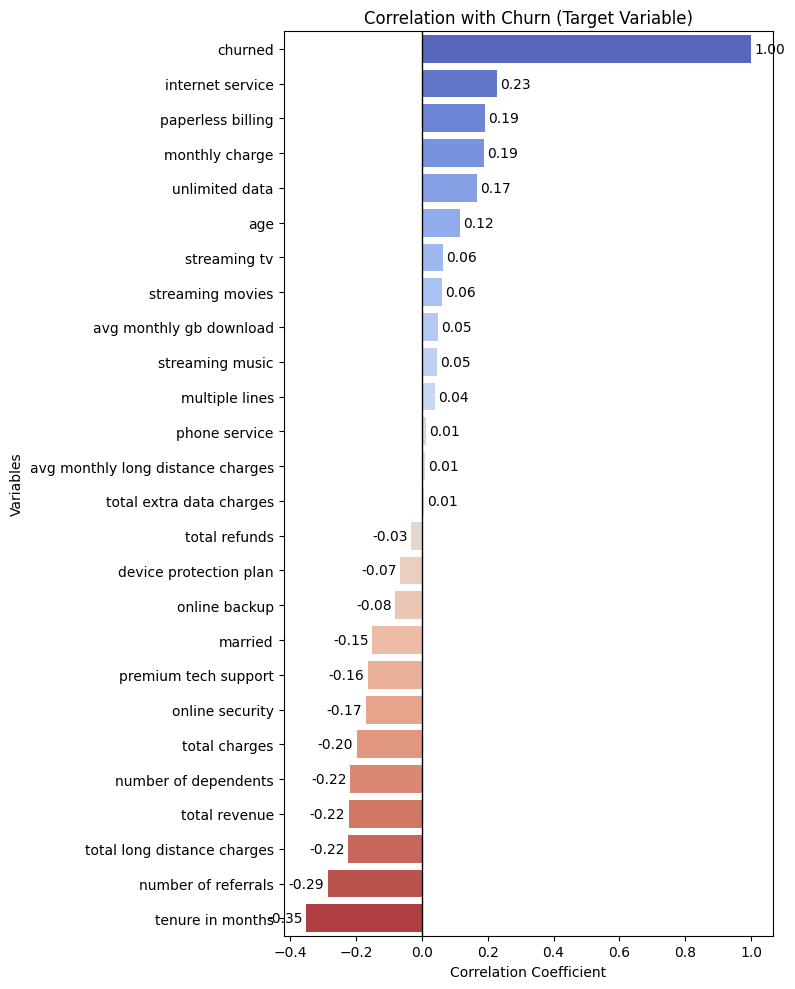

In [ ]:
numeric_for_corr = binarynu_vars + metric_vars

corr_with_target = df[numeric_for_corr].corr()["churned"].sort_values(ascending=False)

plt.figure(figsize=(8,10))

ax = sns.barplot(
    x=corr_with_target.values,
    y=corr_with_target.index,
    hue=corr_with_target.index,
    palette="coolwarm",
    legend=False
)

plt.title("Correlation with Churn (Target Variable)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Variables")
plt.axvline(0, color="black", linewidth=1)

# Add correlation values on bars (rounded to 2 decimals)
for i, v in enumerate(corr_with_target.values):
    ax.text(
        v + (0.01 if v > 0 else -0.01),  # shift text slightly
        i,
        f"{v:.2f}",
        va='center',
        ha='left' if v > 0 else 'right'
    )

plt.tight_layout()
plt.show()

In [ ]:
df[numeric_for_corr].corr(method="spearman")

,married,phone service,multiple lines,internet service,online security,online backup,device protection plan,premium tech support,streaming tv,streaming movies,...,number of referrals,tenure in months,avg monthly long distance charges,avg monthly gb download,monthly charge,total charges,total refunds,total extra data charges,total long distance charges,total revenue
married,1.000000,0.017706,0.142057,-0.000615,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412,...,0.896375,0.386613,0.010713,0.047477,0.107319,0.341787,0.039839,-0.017962,0.264730,0.352560
phone service,0.017706,1.000000,0.279690,-0.172209,-0.092893,-0.052312,-0.071227,-0.096340,-0.022574,-0.032959,...,0.013828,0.008076,0.512454,-0.133108,0.231204,0.084885,0.007019,-0.044374,0.512454,0.162702
multiple lines,0.142057,0.279690,1.000000,0.210564,0.098108,0.202237,0.201137,0.100571,0.257152,0.258751,...,0.117004,0.337896,0.143238,0.134925,0.505647,0.469632,0.043959,0.039678,0.385881,0.461744
internet service,-0.000615,-0.172209,0.210564,1.000000,0.333403,0.381593,0.380754,0.336298,0.415552,0.418675,...,-0.018069,0.039484,-0.073156,0.717342,0.687164,0.386583,0.022112,0.178218,-0.055530,0.275446
online security,0.143106,-0.092893,0.098108,0.333403,1.000000,0.283832,0.275438,0.354931,0.176207,0.187398,...,0.153157,0.329662,-0.030750,0.283365,0.267489,0.408287,0.018851,0.043454,0.166429,0.374499
online backup,0.141498,-0.052312,0.202237,0.381593,0.283832,1.000000,0.303546,0.294233,0.282106,0.274501,...,0.140666,0.360693,-0.015335,0.298556,0.422705,0.490405,0.025541,0.080208,0.209583,0.450564
device protection plan,0.153786,-0.071227,0.201137,0.380754,0.275438,0.303546,1.000000,0.333313,0.390874,0.402111,...,0.150235,0.364020,-0.033612,0.293715,0.466484,0.507622,0.031111,0.059730,0.189056,0.460361
premium tech support,0.119999,-0.096340,0.100571,0.336298,0.354931,0.294233,0.333313,1.000000,0.278070,0.279358,...,0.126703,0.327494,-0.050650,0.275050,0.309664,0.422184,0.034559,0.068374,0.151873,0.383362
streaming tv,0.124666,-0.022574,0.257152,0.415552,0.176207,0.282106,0.390874,0.278070,1.000000,0.533094,...,0.109809,0.284967,0.000869,0.300962,0.623234,0.495590,0.022682,0.064849,0.175210,0.441266
streaming movies,0.117412,-0.032959,0.258751,0.418675,0.187398,0.274501,0.402111,0.279358,0.533094,1.000000,...,0.097139,0.290623,0.002479,0.305703,0.618990,0.500474,0.014898,0.084096,0.179210,0.446540


After accounting for the known dependency between phone and internet services, the correlation analysis shows that the most informative relationships are driven by tenure and cumulative value, rather than basic service availability. Internet-related variables and their add-ons remain strongly correlated with each other, which mainly reflects predefined service bundles rather than independent customer behavior, so these correlations are expected and not directly indicative of churn risk.

The strongest and most meaningful pattern is the role of tenure in months. Tenure is highly positively correlated with total charges and total revenue, and clearly negatively correlated with churn. This confirms that churn is largely a retention-duration issue: customers who stay longer generate more value and are much less likely to leave.

Once service dependency is considered, churn has only weak to moderate correlations with individual services. Customers with higher monthly charges or unlimited data show slightly higher churn, while add-ons such as online security, online backup, device protection, and premium tech support are negatively correlated with churn, suggesting a stabilizing effect rather than a risk factor.

Overall, the correlations indicate that customer longevity and service depth matter more than demographics or standalone services. Revenue patterns are mainly time-driven, and effective churn prevention should focus on early-tenure customers and increasing engagement through value-added services rather than simply expanding core service access.

Trail Test Split

Selecting the Data for Prediction

For the modeling stage, the dataset is prepared using a train–test split with churned as the target variable. To avoid data leakage, all columns that directly describe churn outcomes - customer status, churn category, and churn reason - are removed before training. The feature matrix X therefore contains only information that would be available before a customer churns, while y represents the churn indicator.

In [ ]:
TARGET = "churned"

leakage_cols = ["customer status", "churn category", "churn reason"]

excluded_cols = [
    "gender", "married", "city", "offer",
    "streaming tv", "streaming movies", "streaming music",
    "total charges", "total refunds", "total extra data charges", "total long distance charges",
    "age"
]

# Combine all columns to remove
cols_to_drop = [TARGET] + leakage_cols + excluded_cols

X = df.drop(columns=cols_to_drop, errors="ignore")
y = df[TARGET]


In [ ]:
#Checking leakage

leaky = [c for c in X.columns if "churn" in c.lower() or "status" in c.lower() or "cancel" in c.lower()]
leaky

[]

Based on analysis above, we are using specific fields of dataset and not considering the fields below:

* **`age`** - Excluded from the final feature set due to weak correlation with churn and limited incremental value beyond lifecycle and service engagement variables.
* **`gender`** - Excluded from the final feature set due to the absence of a meaningful relationship with churn and limited predictive value.
* **`married`** - Excluded from the final feature set because its association with churn is weak and largely captured by tenure and service-related variables.
* **`city`** - Excluded from the final feature set due to high cardinality and sparsity, which can introduce noise without providing stable predictive signal.
* **`offer`** - Excluded from the final feature set to avoid potential reverse causality, as offers may be assigned in response to churn risk rather than serving as an independent predictor.
* **`streaming tv`** - Excluded from the final feature set because of high redundancy with other streaming services and limited incremental contribution after accounting for internet service dependency.
* **`streaming movies`** - Excluded from the final feature set due to strong multicollinearity with other streaming variables and weak independent association with churn.
* **`streaming music`** - Excluded from the final feature set for the same reason as other streaming variables, as it does not add distinct predictive information.
* **`total charges`** - Excluded from the final feature set because it is strongly correlated with tenure and represents cumulative customer value rather than churn-driving behavior.
* **`total refunds`** - Excluded from the final feature set due to low variance and sparsity, which limit its usefulness for reliable churn prediction.
* **`total total extra data charges`** - Excluded from the final feature set because it is highly skewed and driven by rare events, contributing noise rather than robust signal.
* **`total total long distance charges`** - Excluded from the final feature set because it is a cumulative metric dominated by tenure effects, while monthly usage measures better capture relevant behavior.

In [ ]:
# Identify feature types from the final X
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object", "category"]).columns

# Preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop",
)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Leakage columns excluded (if present):", [c for c in leakage_cols if c in df.columns])
print("Excluded modeling columns (if present):", [c for c in excluded_cols if c in df.columns])
print("Train size:", X_train.shape, " Test size:", X_test.shape)

Leakage columns excluded (if present): ['customer status', 'churn category', 'churn reason']
Excluded modeling columns (if present): ['gender', 'married', 'city', 'offer', 'streaming tv', 'streaming movies', 'streaming music', 'total charges', 'total refunds', 'total extra data charges', 'total long distance charges', 'age']
Train size: (5634, 20)  Test size: (1409, 20)
